# This is QC on all tumors that have matched tumor pattern

## 1 Functions and module

### 1.1 Modules

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import math
import seaborn as sns
import re
import scipy.stats as SS
%matplotlib inline 
import copy
import scipy

In [3]:
pd.set_option('display.max_columns', None)

### 1.2 Functions

In [4]:
def Final_df_Generation(input_df,input_conversion_factor_df):
    # input_df is the dataframe input
    # input_conversion_factor_df is the dictionary that store the the cell number per reads
    temp_df = input_df.merge(input_conversion_factor_df, on ='Sample_ID')
    temp_df['Cell_number'] = temp_df['Count']*temp_df['Cell_number_per_read']
    return(temp_df)

In [5]:
def Cas12a_array_combination(input_df, n):
    """
    This function creates different combinations of gRNA and gene columns 
    based on the input DataFrame and number of guides/genes provided.
    
    Parameters:
    input_df (DataFrame): The input DataFrame containing gRNA and gene information.
    n (int): The number of gRNAs/genes columns to be combined.

    Returns:
    DataFrame: A new DataFrame with additional columns for ordered and unordered combinations.
    """
    # Copy the input DataFrame to avoid modifying the original
    temp_df = input_df.copy()

    # Generate the list of gRNA and gene column names dynamically based on n
    gRNA_columns = [f'gRNA{i}' for i in range(1, n + 1)]
    gene_columns = [f'Gene{i}' for i in range(1, n + 1)]

    # Generate combinations at gRNA and gene levels
    temp_df['gRNA_combination'] = temp_df[gRNA_columns].agg('_'.join, axis=1)
    temp_df['gRNA_combination_unordered'] = temp_df[gRNA_columns].agg(lambda row: '_'.join(sorted(row)), axis=1)

    temp_df['gene_combination'] = temp_df[gene_columns].agg('_'.join, axis=1)
    temp_df['gene_combination_unordered'] = temp_df[gene_columns].agg(lambda row: '_'.join(sorted(row)), axis=1)

    return temp_df


In [6]:
def Generate_Dataframe_Cas12a(read_df, gRNA_df, mice_df, n, barcode_pattern=False):
    """
    This function generates a combined DataFrame by merging read, gRNA, and mice data, 
    with an optional feature to filter by barcode pattern.
    
    Parameters:
    - read_df (DataFrame): The DataFrame containing read information.
    - gRNA_df (DataFrame): The DataFrame containing gRNA and gene information.
    - mice_df (DataFrame): The DataFrame containing mice metadata.
    - n (int): The number of gRNA per array (array size).
    - barcode_pattern (str or bool, optional): A regex pattern for filtering barcodes.
    
    Returns:
    - DataFrame: The final combined DataFrame.
    """
    # Generate column names dynamically based on array size (n)
    gRNA_columns = [f'gRNA{i}' for i in range(1, n + 1)]
    gene_columns = [f'Gene{i}' for i in range(1, n + 1)]
    guide_columns = [f'Guide{i}' for i in range(1, n + 1)]

    temp_gRNA_info_columns = ['gRNA_combination', 'gene_combination', 
                              'gene_combination_unordered', 'gRNA_combination_unordered', 
                              'Array_category']

    # Combine all required columns into a list
    required_gRNA_columns = gRNA_columns + gene_columns + guide_columns + temp_gRNA_info_columns

    # Check if gRNA_df contains all required columns
    missing_gRNA_columns = [col for col in required_gRNA_columns if col not in gRNA_df.columns]
    if missing_gRNA_columns:
        raise ValueError(f"The following required columns are missing from gRNA_df: {missing_gRNA_columns}")

    # Define the columns from mice_df to merge
    mice_columns = ['Sample_ID', 'Mouse_genotype', 'Virus_titer', 'Time_after_tumor_initiation', 
                    'Total_lung_weight', 'Sex']

    # Check if mice_df contains all required columns
    missing_mice_columns = [col for col in mice_columns if col not in mice_df.columns]
    if missing_mice_columns:
        raise ValueError(f"The following required columns are missing from mice_df: {missing_mice_columns}")

    # Merge read_df with gRNA_df on shared gRNA columns and combination column
    temp_shared_columns = gRNA_columns + ['gRNA_combination']
    read_df = read_df.merge(gRNA_df, on=temp_shared_columns, how='left')

    # Merge read_df with mice_df on 'Sample_ID'
    Output_df = read_df.merge(mice_df[mice_columns], on='Sample_ID', how='left')

    # If barcode_pattern is provided, filter the Output_df by the specified pattern
    if barcode_pattern:
        # Compile the regex pattern
        temp_pattern = re.compile(barcode_pattern)

        # Initialize the 'Project_barcode' column with 'Spikein_barcode'
        Output_df['Project_barcode'] = 'Spikein_barcode'

        # Apply regex pattern to 'Clonal_barcode' to determine match status
        Output_df.loc[Output_df['Array_category'] != 'Spikein', 'Project_barcode'] = Output_df.loc[
            Output_df['Array_category'] != 'Spikein', 'Clonal_barcode'
        ].apply(lambda x: 'Match' if temp_pattern.search(x) else 'Unmatch')
    else:
        Output_df['Project_barcode'] = 'Spikein_barcode'
        Output_df.loc[Output_df['Array_category'] != 'Spikein', 'Project_barcode'] = 'No_pattern'
    
    return Output_df



In [7]:

def Spikein_summary_Cas12a(input_df, input_cell_number):
    """
    This function extracts spike-in reads for each kind in each sample and assigns a unique name for each spike-in.
    
    Parameters:
    - input_df (DataFrame): The input DataFrame containing reads and metadata.
    - input_cell_number (int or float): Total cell number used to calculate 'Cell_per_read'.
    
    Returns:
    - DataFrame: A summary DataFrame containing information about spike-ins per sample.
    """
    
    # Select spike-in rows only
    temp_df = input_df[input_df['Array_category'] == 'Spikein']
    
    # Group by 'Sample_ID' and 'gRNA_combination', aggregating the required metrics
    temp_df = temp_df.groupby(['Sample_ID', 'gRNA_combination'], as_index=False).agg(
        Unique_spikein_barcode_number=pd.NamedAgg(column='Clonal_barcode', aggfunc=lambda x: len(x.unique())),  # Number of unique spike-in barcodes
        Count=pd.NamedAgg(column='Count', aggfunc=np.sum)
    )
    
    # Sort and assign a unique name to each unique 'gRNA_combination' per 'Sample_ID'
    temp_df = temp_df.sort_values(by=['Sample_ID', 'gRNA_combination']).reset_index(drop=True)
    
    # Assigning 'Spikein1', 'Spikein2', etc. to each unique gRNA_combination per sample
    temp_df['Spikein_name'] = temp_df.groupby('Sample_ID').cumcount().apply(lambda x: f'Spikein{x + 1}')
    
    # Calculate 'Cell_per_read'
    temp_df['Cell_per_read'] = input_cell_number / temp_df['Count']
    
    # Calculate 'Amplification' as Count per unique spike-in barcode
    temp_df['Amplification'] = temp_df['Count'] / temp_df['Unique_spikein_barcode_number']
    
    return temp_df



In [8]:
def cal_spikein_ratio(x):
    """
    Calculate the ratios between spike-in gRNA counts for a given sample.
    
    Parameters:
    - x (DataFrame): Subset of spikein_df containing data for a single 'Sample_ID'.
    
    Returns:
    - Series: A pandas Series containing mean count, spike-in ratios, and the max-to-least ratio.
    """
    d = {}
    
    # Extract the count values for each unique 'gRNA_combination' and sort by 'gRNA_combination'
    temp_vect = x[['gRNA_combination', 'Count','Spikein_name']].sort_values(by='gRNA_combination').reset_index(drop=True)
    
    # Ensure there are exactly three unique gRNA_combinations
    unique_gRNAs = temp_vect['gRNA_combination'].unique()
    if len(unique_gRNAs) != 3:
        raise ValueError(f"Expected 3 unique gRNA_combinations for Sample_ID {x['Sample_ID'].iloc[0]}, "
                         f"but found {len(unique_gRNAs)}")


    
    # Extract count values for each of the three gRNAs
    s1_value = temp_vect['Count'].iloc[0]
    s2_value = temp_vect['Count'].iloc[1]
    s3_value = temp_vect['Count'].iloc[2]

    # Calculate the mean count
    d['Mean_count'] = (s1_value + s2_value + s3_value) / 3
    
    # Calculate ratios, avoiding division by zero
    d['s1_s2_ratio'] = s1_value / s2_value if s2_value != 0 else None
    d['s1_s3_ratio'] = s1_value / s3_value if s3_value != 0 else None

    # Calculate max-to-least ratio
    values_sorted = sorted([s1_value, s2_value, s3_value])
    d['max_least_ratio'] = values_sorted[-1] / values_sorted[0] if values_sorted[0] != 0 else None
    # Extract gRNA combination names and count values
    d['Spikein1'] = temp_vect['gRNA_combination'].iloc[0]
    d['Spikein2'] = temp_vect['gRNA_combination'].iloc[1]
    d['Spikein3'] = temp_vect['gRNA_combination'].iloc[2]
    return pd.Series(d)

In [9]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']),size = 8)

In [10]:
def Generate_Conversion_factor(input_spike_df, input_candidate_list, input_spike_in_list,temp_spikein_cell_number):
    # this function generate a df storing cell number per reads
    # input_spike_df is the df contain the spikein information (spikein_ratio_df)
    # temp_spikein_cell_number is the cell number for each spike in added into sample (usually it is 100K)
    # for most sample, I will use temp_spikein_cell_number/ mean(spike in reads)
    # input_candidate_list is the list of sample id whose spikein needed special treatment
    # temp_spikein_cell_number specify which spike in will be use for each sample ID who need special treatment
    input_dic = dict(zip(input_candidate_list, input_spike_in_list))
    temp_dic = {}
    for index,row in input_spike_df.iterrows():
        temp_id = row['Sample_ID']
        if temp_id in input_dic.keys():
            # print(row[input_dic.get(id)])
            temp_value = row[input_dic.get(temp_id)].mean()
        else:
            temp_value = row['Mean_count']
        temp_dic[temp_id] = temp_spikein_cell_number/temp_value
    temp_df = pd.DataFrame({'Sample_ID':temp_dic.keys(),
                       'Cell_number_per_read':temp_dic.values()})
    temp_df['Correction_for_spikein'] = temp_df['Sample_ID'].apply(lambda x: 'Yes' if (x in input_candidate_list) else 'No')
    return(temp_df.sort_values(by=['Correction_for_spikein','Cell_number_per_read']))

In [11]:
# calculate the summary metrics for each sample
def Cal_Sample_Summary(x):
    d = {}
    temp_vect = x['Cell_number']
    if type (temp_vect) == 'int':
        temp_vect = [temp_vect]
    d['array_recovered'] = len(x['gRNA_combination'].unique())
    d['TTB'] = sum(temp_vect) # total mutational burdern 
    d['TTN'] = len(temp_vect) # this is total tumor number
    return pd.Series(d, index=list(d.keys())) 

In [12]:
def Generate_Sample_Summary_Ca12a(input_df, spikein_df, cell_number_cutoff, read_cutoff):
    """
    Generate summary statistics per sample from CRISPR-Cas12a tumor profiling data.

    Parameters:
    - input_df: DataFrame with raw tumor data
    - spikein_df: DataFrame containing spike-in control information
    - cell_number_cutoff: Minimum number of cells per tumor to include
    - read_cutoff: Minimum number of reads per tumor to include

    Returns:
    - DataFrame with per-sample summary statistics
    """

    # Step 1: Calculate total tumor reads (TTR) per sample without filtering
    summary_cols = [
        'Sample_ID', 'Mouse_genotype', 'Sex',
        'Time_after_tumor_initiation', 'Total_lung_weight',
        'Virus_titer', 'Correction_for_spikein', 'Cell_number_per_read'
    ]

    total_reads_df = input_df.groupby(summary_cols, as_index=False).agg(
        TTR=pd.NamedAgg(column='Count', aggfunc='sum')
    )

    # Step 2: Merge spike-in information
    total_reads_df = total_reads_df.merge(
        spikein_df[['Sample_ID', 'Mean_count', 'max_least_ratio']],
        on='Sample_ID', how='left'
    )

    # Step 3: Calculate spike-in read ratio
    total_reads_df['Spikein_read_ratio'] = (
        total_reads_df['Mean_count'] * 3
    ) / (
        total_reads_df['TTR'] + total_reads_df['Mean_count'] * 3
    )

    # Step 4: Filter input tumors based on cell number and read count
    filtered_df = input_df[
        (input_df['Cell_number'] >= cell_number_cutoff) &
        (input_df['Count'] >= read_cutoff)
    ]

    # Step 5: Compute per-sample tumor summary from filtered data
    sample_summary = filtered_df.groupby('Sample_ID', as_index=False).apply(
        Cal_Sample_Summary
    )

    # Step 6: Normalize tumor burden to millions
    sample_summary['TTB_million'] = sample_summary['TTB'] / 1e6

    # Step 7: Merge tumor summary with sample metadata
    merged_df = sample_summary.merge(total_reads_df, on='Sample_ID', how='right')

    # Step 8: Normalize tumor numbers per 100K virus genomes
    merged_df['Tumor number per 100K virus'] = (
        merged_df['TTN'] / merged_df['Virus_titer'] * 1e5
    )

    # Step 9: Normalize tumor burden per 100K virus, log-transformed
    merged_df['Total tumor burden (million per 100K virus)'] = np.log10(
        merged_df['TTB_million'] / merged_df['Virus_titer'] * 1e5
    )

    # Step 10: Normalize tumor burden per mg of lung
    merged_df['TTB_per_mg'] = (
        merged_df['TTB'] / (merged_df['Total_lung_weight'] - 0.15) / 1000
    )
    merged_df['Read_cutoff'] = read_cutoff
    merged_df['Cell_number_cutoff'] = cell_number_cutoff
    return merged_df

----

## 2 Input and output address

In [13]:
project_dir = "/labs/mwinslow/Haiqing/UltraSeq_Projects/Kat7_dual_guide_tumor/"
data_address = project_dir + "01_data_collection/data/Processed_data/gRNA_clonalbarcode_combined.csv"
read_distribution_address = project_dir + "01_data_collection/data/reads_distribution_summary.csv"
working_dir = project_dir+"02_data_cleaning_and_QC/data/"
# gRNA information address
gRNA_info_address = working_dir + "guide_reference-kat7_array.csv"
# experimental information address
exp_info_address = working_dir + "Mice_info_standardized_Kat7_DualGuide.csv"

In [14]:
cell_line_number = 100000

In [15]:
project_prefix = 'Kat7_DualGuide'
sample_summary_address = working_dir + f"{project_prefix}_sample_summary_df.csv"
annotated_data_output_address = working_dir + f"{project_prefix}_annotated_df.parquet"
final_data_output_address = working_dir + f"{project_prefix}_final_df.parquet"
inert_combined_final_data_output_address = working_dir + f"{project_prefix}_inert_combined_df.parquet"
no_template_switching_inert_combined_final_data_output_address = working_dir + f"{project_prefix}_no_TS_inert_combined_df.parquet"
read_dist_output_address = working_dir + f"{project_prefix}_dist_final_df.csv"

In [16]:
fig_dir = 'fig/'
fig_output_address1 = fig_dir + f"{project_prefix}_reads_dist.pdf"
fig_output_address2 = fig_dir + f"{project_prefix}_QC_plot.pdf"

In [17]:
# genotype_colors = {'KT': '#feb24c', 'KTHC': '#7fcdbb', 'BTHC': '#2c7fb8'}
genotype_colors = {'KT': '#feb24c', 'KTHC': '#7fcdbb'}

---

## 3 Data Input and simple QC

### 3.1 Read mice info

In [17]:
mice_info = pd.read_csv(exp_info_address)

In [18]:
mice_info.rename(columns = {'Sample ID':'Sample_ID','Mouse_Genotype':'Mouse_genotype',
                            'Virus_Titer':'Virus_titer','Time_After_Tumor_Initiation(wks)':'Time_after_tumor_initiation',
                                 'Total_Lung_Weight(g)':'Total_lung_weight'}, inplace = True)

In [19]:
mice_info.head()

,Sample_ID,Mouse_Ear_Tag,Mouse_genotype,Sex,Virus_titer,Time_after_tumor_initiation,Total_lung_weight,Tissue
0,LA92_01,SL1613,KT,F,330000,16,0.332,Lung
1,LA92_02,SL1623,KT,F,330000,16,0.423,Lung
2,LA92_03,SL1664,KT,F,330000,16,0.203,Lung
3,LA92_04,SL1621,KT,M,330000,16,0.401,Lung
4,LA92_05,SL1622,KT,M,330000,16,0.761,Lung


### 3.2 Read NGS data for tumor

In [20]:
raw_df = pd.read_csv(data_address)
raw_df = raw_df.rename(columns = {'Frequency':'Count'})
raw_df.head()

,gRNA_combination,Clonal_barcode,gRNA1,gRNA2,Sample_ID,Count
0,AAAGGGGTCGTAAACGCAGG_AAAAATTTAGCTAAACCAG,AAAGGAGATCTTTTTC,AAAGGGGTCGTAAACGCAGG,AAAAATTTAGCTAAACCAG,LA92_10,3
1,AAAGGGGTCGTAAACGCAGG_AAAAATTTAGCTAAACCAG,AATCGATATTTCAGGT,AAAGGGGTCGTAAACGCAGG,AAAAATTTAGCTAAACCAG,LA92_10,1
2,AAAGGGGTCGTAAACGCAGG_AAAAATTTAGCTAAACCAG,ACCCAACATATGTCTG,AAAGGGGTCGTAAACGCAGG,AAAAATTTAGCTAAACCAG,LA92_10,3
3,AAAGGGGTCGTAAACGCAGG_AAAAATTTAGCTAAACCAG,ACGGAAGATGTCTTGA,AAAGGGGTCGTAAACGCAGG,AAAAATTTAGCTAAACCAG,LA92_10,1
4,AAAGGGGTCGTAAACGCAGG_AAAAATTTAGCTAAACCAG,ACTTTAAATTTGCGGT,AAAGGGGTCGTAAACGCAGG,AAAAATTTAGCTAAACCAG,LA92_10,3


In [21]:
r_test = raw_df[raw_df.Sample_ID=='LA92_01']

In [22]:
r_test[r_test.gRNA1=='ACCTTACAATGTTATATT']

,gRNA_combination,Clonal_barcode,gRNA1,gRNA2,Sample_ID,Count
1057768,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CCTGAGAGGCCATGTT,ACCTTACAATGTTATATT,ACTAGCAGGTGACACCACCTGCATCA,LA92_01,1
1057769,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CTCGAGAGGCAATGTT,ACCTTACAATGTTATATT,ACTAGCAGGTGACACCACCTGCATCA,LA92_01,1
1057770,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CTCGAGAGGCCATGTT,ACCTTACAATGTTATATT,ACTAGCAGGTGACACCACCTGCATCA,LA92_01,1
1057771,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CTTGAGAAGCCATGTT,ACCTTACAATGTTATATT,ACTAGCAGGTGACACCACCTGCATCA,LA92_01,1
1057772,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CTTGAGAGACCATGTT,ACCTTACAATGTTATATT,ACTAGCAGGTGACACCACCTGCATCA,LA92_01,2
1057773,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CTTGAGAGGACATGTT,ACCTTACAATGTTATATT,ACTAGCAGGTGACACCACCTGCATCA,LA92_01,1
1057774,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CTTGAGAGGCAATGTT,ACCTTACAATGTTATATT,ACTAGCAGGTGACACCACCTGCATCA,LA92_01,17
1057775,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CTTGAGAGGCCACGTT,ACCTTACAATGTTATATT,ACTAGCAGGTGACACCACCTGCATCA,LA92_01,4
1057776,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CTTGAGAGGCCATGCT,ACCTTACAATGTTATATT,ACTAGCAGGTGACACCACCTGCATCA,LA92_01,2
1057777,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CTTGAGAGGCCATGTC,ACCTTACAATGTTATATT,ACTAGCAGGTGACACCACCTGCATCA,LA92_01,2


In [23]:
raw_df.shape

(1080535, 6)

In [24]:
raw_df.Sample_ID.unique()

array(['LA92_10', 'LA92_26', 'LA92_11', 'LA92_25', 'LA92_17', 'LA92_21',
       'LA92_12', 'LA92_14', 'LA92_19', 'LA92_20', 'LA92_03', 'LA92_22',
       'LA92_02', 'LA92_07', 'LA92_27', 'LA92_28', 'LA92_29', 'LA92_15',
       'LA92_04', 'LA92_05', 'LA92_18', 'LA92_16', 'LA92_23', 'LA92_06',
       'LA92_24', 'LA92_08', 'LA92_01'], dtype=object)

### 3.3 Read gRNA info

In [25]:
ref_df = pd.read_csv(gRNA_info_address)

In [26]:
ref_df.head()

,Gene1,gRNA1,Guide1,Gene2,gRNA2,Guide2,gRNA_combination,Array_category
0,NT_1,CACGGGCAGCGATCTAGTTG,NT_1,NT_1,CACGGGCAGCGATCTAGTTG,NT_1,CACGGGCAGCGATCTAGTTG_CACGGGCAGCGATCTAGTTG,Kat7
1,NT_1,CACGGGCAGCGATCTAGTTG,NT_1,NT_2,CTTCACGCCTTGGACCGATA,NT_2,CACGGGCAGCGATCTAGTTG_CTTCACGCCTTGGACCGATA,Kat7
2,NT_1,CACGGGCAGCGATCTAGTTG,NT_1,Safe_16,AGTACACTATAGTGGCTAGT,Safe_16,CACGGGCAGCGATCTAGTTG_AGTACACTATAGTGGCTAGT,Kat7
3,NT_1,CACGGGCAGCGATCTAGTTG,NT_1,Safe_37,ATGTAGGAGCTATAACATC,Safe_37,CACGGGCAGCGATCTAGTTG_ATGTAGGAGCTATAACATC,Kat7
4,NT_1,CACGGGCAGCGATCTAGTTG,NT_1,Epc1,CTATGAGTCCATATACCCTG,Epc1_1,CACGGGCAGCGATCTAGTTG_CTATGAGTCCATATACCCTG,Kat7


In [27]:
ref_df = Cas12a_array_combination(ref_df,2)

In [28]:
ref_df

,Gene1,gRNA1,Guide1,Gene2,gRNA2,Guide2,gRNA_combination,Array_category,gRNA_combination_unordered,gene_combination,gene_combination_unordered
0,NT_1,CACGGGCAGCGATCTAGTTG,NT_1,NT_1,CACGGGCAGCGATCTAGTTG,NT_1,CACGGGCAGCGATCTAGTTG_CACGGGCAGCGATCTAGTTG,Kat7,CACGGGCAGCGATCTAGTTG_CACGGGCAGCGATCTAGTTG,NT_1_NT_1,NT_1_NT_1
1,NT_1,CACGGGCAGCGATCTAGTTG,NT_1,NT_2,CTTCACGCCTTGGACCGATA,NT_2,CACGGGCAGCGATCTAGTTG_CTTCACGCCTTGGACCGATA,Kat7,CACGGGCAGCGATCTAGTTG_CTTCACGCCTTGGACCGATA,NT_1_NT_2,NT_1_NT_2
2,NT_1,CACGGGCAGCGATCTAGTTG,NT_1,Safe_16,AGTACACTATAGTGGCTAGT,Safe_16,CACGGGCAGCGATCTAGTTG_AGTACACTATAGTGGCTAGT,Kat7,AGTACACTATAGTGGCTAGT_CACGGGCAGCGATCTAGTTG,NT_1_Safe_16,NT_1_Safe_16
3,NT_1,CACGGGCAGCGATCTAGTTG,NT_1,Safe_37,ATGTAGGAGCTATAACATC,Safe_37,CACGGGCAGCGATCTAGTTG_ATGTAGGAGCTATAACATC,Kat7,ATGTAGGAGCTATAACATC_CACGGGCAGCGATCTAGTTG,NT_1_Safe_37,NT_1_Safe_37
4,NT_1,CACGGGCAGCGATCTAGTTG,NT_1,Epc1,CTATGAGTCCATATACCCTG,Epc1_1,CACGGGCAGCGATCTAGTTG_CTATGAGTCCATATACCCTG,Kat7,CACGGGCAGCGATCTAGTTG_CTATGAGTCCATATACCCTG,NT_1_Epc1,Epc1_NT_1
...,...,...,...,...,...,...,...,...,...,...,...
382,Meaf6,CCAATAGCAAAAACGACCGG,Meaf6_2,Psip1,AAAAATTTAGCTAAACCAG,Psip1_1,CCAATAGCAAAAACGACCGG_AAAAATTTAGCTAAACCAG,Kat7,AAAAATTTAGCTAAACCAG_CCAATAGCAAAAACGACCGG,Meaf6_Psip1,Meaf6_Psip1
383,Meaf6,CCAATAGCAAAAACGACCGG,Meaf6_2,Psip1,ACTCCAAAAGCTGCCAGGCG,Psip1_2,CCAATAGCAAAAACGACCGG_ACTCCAAAAGCTGCCAGGCG,Kat7,ACTCCAAAAGCTGCCAGGCG_CCAATAGCAAAAACGACCGG,Meaf6_Psip1,Meaf6_Psip1
384,Spikein_1,ACCTTACAATGTTATATT,Spikein_1,Spikein_4,ACTAGCAGGTGACACCACCTGCATCA,Spikein_4,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,Spikein,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,Spikein_1_Spikein_4,Spikein_1_Spikein_4
385,Spikein_2,GTGACACTTTCTATTAGGT,Spikein_2,Spikein_4,ACTAGCAGGTGACACCACCTGCATCA,Spikein_4,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA,Spikein,ACTAGCAGGTGACACCACCTGCATCA_GTGACACTTTCTATTAGGT,Spikein_2_Spikein_4,Spikein_2_Spikein_4


### 3.4 Merge all df

In [29]:
raw_df.shape

(1080535, 6)

In [30]:
temp_raw_read = Generate_Dataframe_Cas12a(raw_df,ref_df,mice_info,2,barcode_pattern='(.{5}A.{1}AT.{1}T.{5})')
temp1 = temp_raw_read['Count'].sum()  # match + unmatch barcode
temp2 = temp_raw_read[temp_raw_read['Clonal_barcode'] == 'CTTGAGAGGCCATGTT']['Count'].sum()  # match barcode
percent = temp2 / temp1 if temp1 > 0 else 0
print(f'{percent:.1%} reads are coming from unbarcode UltraSeq backbone, which is about {temp2:.1e} reads')
# temp_raw_read = temp_raw_read[temp_raw_read.Clonal_barcode!='CTTGAGAGGCCATGTT'] # exclude barcode filler
# the spike barcode is the unbarcode

29.2% reads are coming from unbarcode UltraSeq backbone, which is about 1.2e+07 reads


### 3.5 Simple summary 

In [31]:
# for non-spikein reads, how many of them have expected barcode pattern
for sample_id, group in temp_raw_read.groupby('Sample_ID'):
    temp1 = group[group['Project_barcode'] != 'Spikein_barcode']['Count'].sum()  # match + unmatch barcode
    temp2 = group[group['Project_barcode'] == 'Match']['Count'].sum()  # match barcode
    percent = temp2 / temp1 if temp1 > 0 else 0
    print(f'{sample_id}: {percent:.1%} reads have expected barcode pattern, which is about {temp2:.1e} reads')

LA92_01: 72.1% reads have expected barcode pattern, which is about 4.5e+05 reads
LA92_02: 73.4% reads have expected barcode pattern, which is about 8.8e+05 reads
LA92_03: 82.9% reads have expected barcode pattern, which is about 9.8e+02 reads
LA92_04: 75.1% reads have expected barcode pattern, which is about 9.3e+05 reads
LA92_05: 72.6% reads have expected barcode pattern, which is about 3.0e+06 reads
LA92_06: 71.9% reads have expected barcode pattern, which is about 7.4e+05 reads
LA92_07: 76.0% reads have expected barcode pattern, which is about 2.0e+06 reads
LA92_08: 75.7% reads have expected barcode pattern, which is about 2.9e+06 reads
LA92_10: 72.5% reads have expected barcode pattern, which is about 1.1e+06 reads
LA92_11: 72.2% reads have expected barcode pattern, which is about 6.8e+03 reads
LA92_12: 71.2% reads have expected barcode pattern, which is about 1.5e+06 reads
LA92_14: 73.5% reads have expected barcode pattern, which is about 8.5e+05 reads
LA92_15: 68.2% reads have ex

In [32]:
processed_df = temp_raw_read[temp_raw_read.Project_barcode!='Unmatch'].copy()

In [33]:
processed_df.head()

,gRNA_combination,Clonal_barcode,gRNA1,gRNA2,Sample_ID,Count,Gene1,Guide1,Gene2,Guide2,Array_category,gRNA_combination_unordered,gene_combination,gene_combination_unordered,Mouse_genotype,Virus_titer,Time_after_tumor_initiation,Total_lung_weight,Sex,Project_barcode
0,AAAGGGGTCGTAAACGCAGG_AAAAATTTAGCTAAACCAG,AAAGGAGATCTTTTTC,AAAGGGGTCGTAAACGCAGG,AAAAATTTAGCTAAACCAG,LA92_10,3,Kat6b,Kat6b_1,Psip1,Psip1_1,Kat7,AAAAATTTAGCTAAACCAG_AAAGGGGTCGTAAACGCAGG,Kat6b_Psip1,Kat6b_Psip1,KTHC,330000,16,0.402,F,Match
1,AAAGGGGTCGTAAACGCAGG_AAAAATTTAGCTAAACCAG,AATCGATATTTCAGGT,AAAGGGGTCGTAAACGCAGG,AAAAATTTAGCTAAACCAG,LA92_10,1,Kat6b,Kat6b_1,Psip1,Psip1_1,Kat7,AAAAATTTAGCTAAACCAG_AAAGGGGTCGTAAACGCAGG,Kat6b_Psip1,Kat6b_Psip1,KTHC,330000,16,0.402,F,Match
2,AAAGGGGTCGTAAACGCAGG_AAAAATTTAGCTAAACCAG,ACCCAACATATGTCTG,AAAGGGGTCGTAAACGCAGG,AAAAATTTAGCTAAACCAG,LA92_10,3,Kat6b,Kat6b_1,Psip1,Psip1_1,Kat7,AAAAATTTAGCTAAACCAG_AAAGGGGTCGTAAACGCAGG,Kat6b_Psip1,Kat6b_Psip1,KTHC,330000,16,0.402,F,Match
3,AAAGGGGTCGTAAACGCAGG_AAAAATTTAGCTAAACCAG,ACGGAAGATGTCTTGA,AAAGGGGTCGTAAACGCAGG,AAAAATTTAGCTAAACCAG,LA92_10,1,Kat6b,Kat6b_1,Psip1,Psip1_1,Kat7,AAAAATTTAGCTAAACCAG_AAAGGGGTCGTAAACGCAGG,Kat6b_Psip1,Kat6b_Psip1,KTHC,330000,16,0.402,F,Match
4,AAAGGGGTCGTAAACGCAGG_AAAAATTTAGCTAAACCAG,ACTTTAAATTTGCGGT,AAAGGGGTCGTAAACGCAGG,AAAAATTTAGCTAAACCAG,LA92_10,3,Kat6b,Kat6b_1,Psip1,Psip1_1,Kat7,AAAAATTTAGCTAAACCAG_AAAGGGGTCGTAAACGCAGG,Kat6b_Psip1,Kat6b_Psip1,KTHC,330000,16,0.402,F,Match


In [34]:
# Group by 'Sample_ID' and calculate sum of count
# I only focus on barcode with matched pattern
# these are reads with expected guide array and clonal barcode pattern
result = processed_df.groupby(['Sample_ID','Mouse_genotype','Project_barcode','Total_lung_weight'], as_index=False).agg(
    reads_after_filtering=('Count', 'sum'),  # Sum of 'Count'
)
result.head()

,Sample_ID,Mouse_genotype,Project_barcode,Total_lung_weight,reads_after_filtering
0,LA92_01,KT,Match,0.332,454444
1,LA92_01,KT,Spikein_barcode,0.332,8347
2,LA92_02,KT,Match,0.423,877249
3,LA92_02,KT,Spikein_barcode,0.423,5068
4,LA92_03,KT,Match,0.203,975


In [35]:
pivot_result = result.pivot(index=["Sample_ID","Mouse_genotype","Total_lung_weight"], 
                            columns="Project_barcode", 
                            values="reads_after_filtering").reset_index()

# Optional: Remove the column index name for clarity
pivot_result.columns.name = None
pivot_result.head()

,Sample_ID,Mouse_genotype,Total_lung_weight,Match,Spikein_barcode
0,LA92_01,KT,0.332,454444,8347
1,LA92_02,KT,0.423,877249,5068
2,LA92_03,KT,0.203,975,111971
3,LA92_04,KT,0.401,930432,11090
4,LA92_05,KT,0.761,2971023,6801


In [36]:
pivot_result = result.pivot(index=["Sample_ID","Mouse_genotype","Total_lung_weight"], 
                            columns="Project_barcode", 
                            values="reads_after_filtering").reset_index()

# Optional: Remove the column index name for clarity
pivot_result.columns.name = None
pivot_result.head()

,Sample_ID,Mouse_genotype,Total_lung_weight,Match,Spikein_barcode
0,LA92_01,KT,0.332,454444,8347
1,LA92_02,KT,0.423,877249,5068
2,LA92_03,KT,0.203,975,111971
3,LA92_04,KT,0.401,930432,11090
4,LA92_05,KT,0.761,2971023,6801


In [37]:
read_dist_df = pd.read_csv(read_distribution_address)
read_dist_df = read_dist_df.merge(pivot_result, on='Sample_ID').drop(columns=['Address_r1', 'Address_r2','frac_unexpected','frac_expected','unexpected_reads_with_guides','expected_reads_with_guides'], errors='ignore')  

In [38]:
read_dist_df = read_dist_df.rename(columns = {'Match':'reads_after_filtering',
                                             'Spikein_barcode':'reads_spikein'})

In [39]:
read_dist_df['frac_final'] = (
    read_dist_df['reads_after_filtering'] / read_dist_df['total_raw_reads']
)
read_dist_df['frac_spikein'] = (
    read_dist_df['reads_spikein'] / read_dist_df['total_raw_reads']
)

read_dist_df['reads_wo_pattern'] = read_dist_df['total_raw_reads'] - read_dist_df['lowQ_reads'] - read_dist_df['reads_after_filtering'] - read_dist_df['reads_spikein'] 

read_dist_df['frac_wo_pattern'] = (
    read_dist_df['reads_wo_pattern'] / read_dist_df['total_raw_reads']
)

In [40]:
read_dist_df.head()

,Sample_ID,total_raw_reads,lowQ_reads,frac_lowQ_reads,Mouse_genotype,Total_lung_weight,reads_after_filtering,reads_spikein,frac_final,frac_spikein,reads_wo_pattern,frac_wo_pattern
0,LA92_10,3860436,2213659,0.573422,KTHC,0.402,1104567,4866,0.286125,0.001260,537344,0.139193
1,LA92_26,8284136,4934649,0.595675,KTHC,0.691,2260795,6018,0.272907,0.000726,1082674,0.130692
2,LA92_11,409812,383559,0.935939,KTHC,0.209,6758,166834,0.016490,0.407099,-147339,-0.359528
3,LA92_25,3532106,2019844,0.571853,KTHC,0.440,1006414,9627,0.284933,0.002726,496221,0.140489
4,LA92_17,3384786,1786530,0.527812,KTHC,0.380,1129233,6463,0.333620,0.001909,462560,0.136659


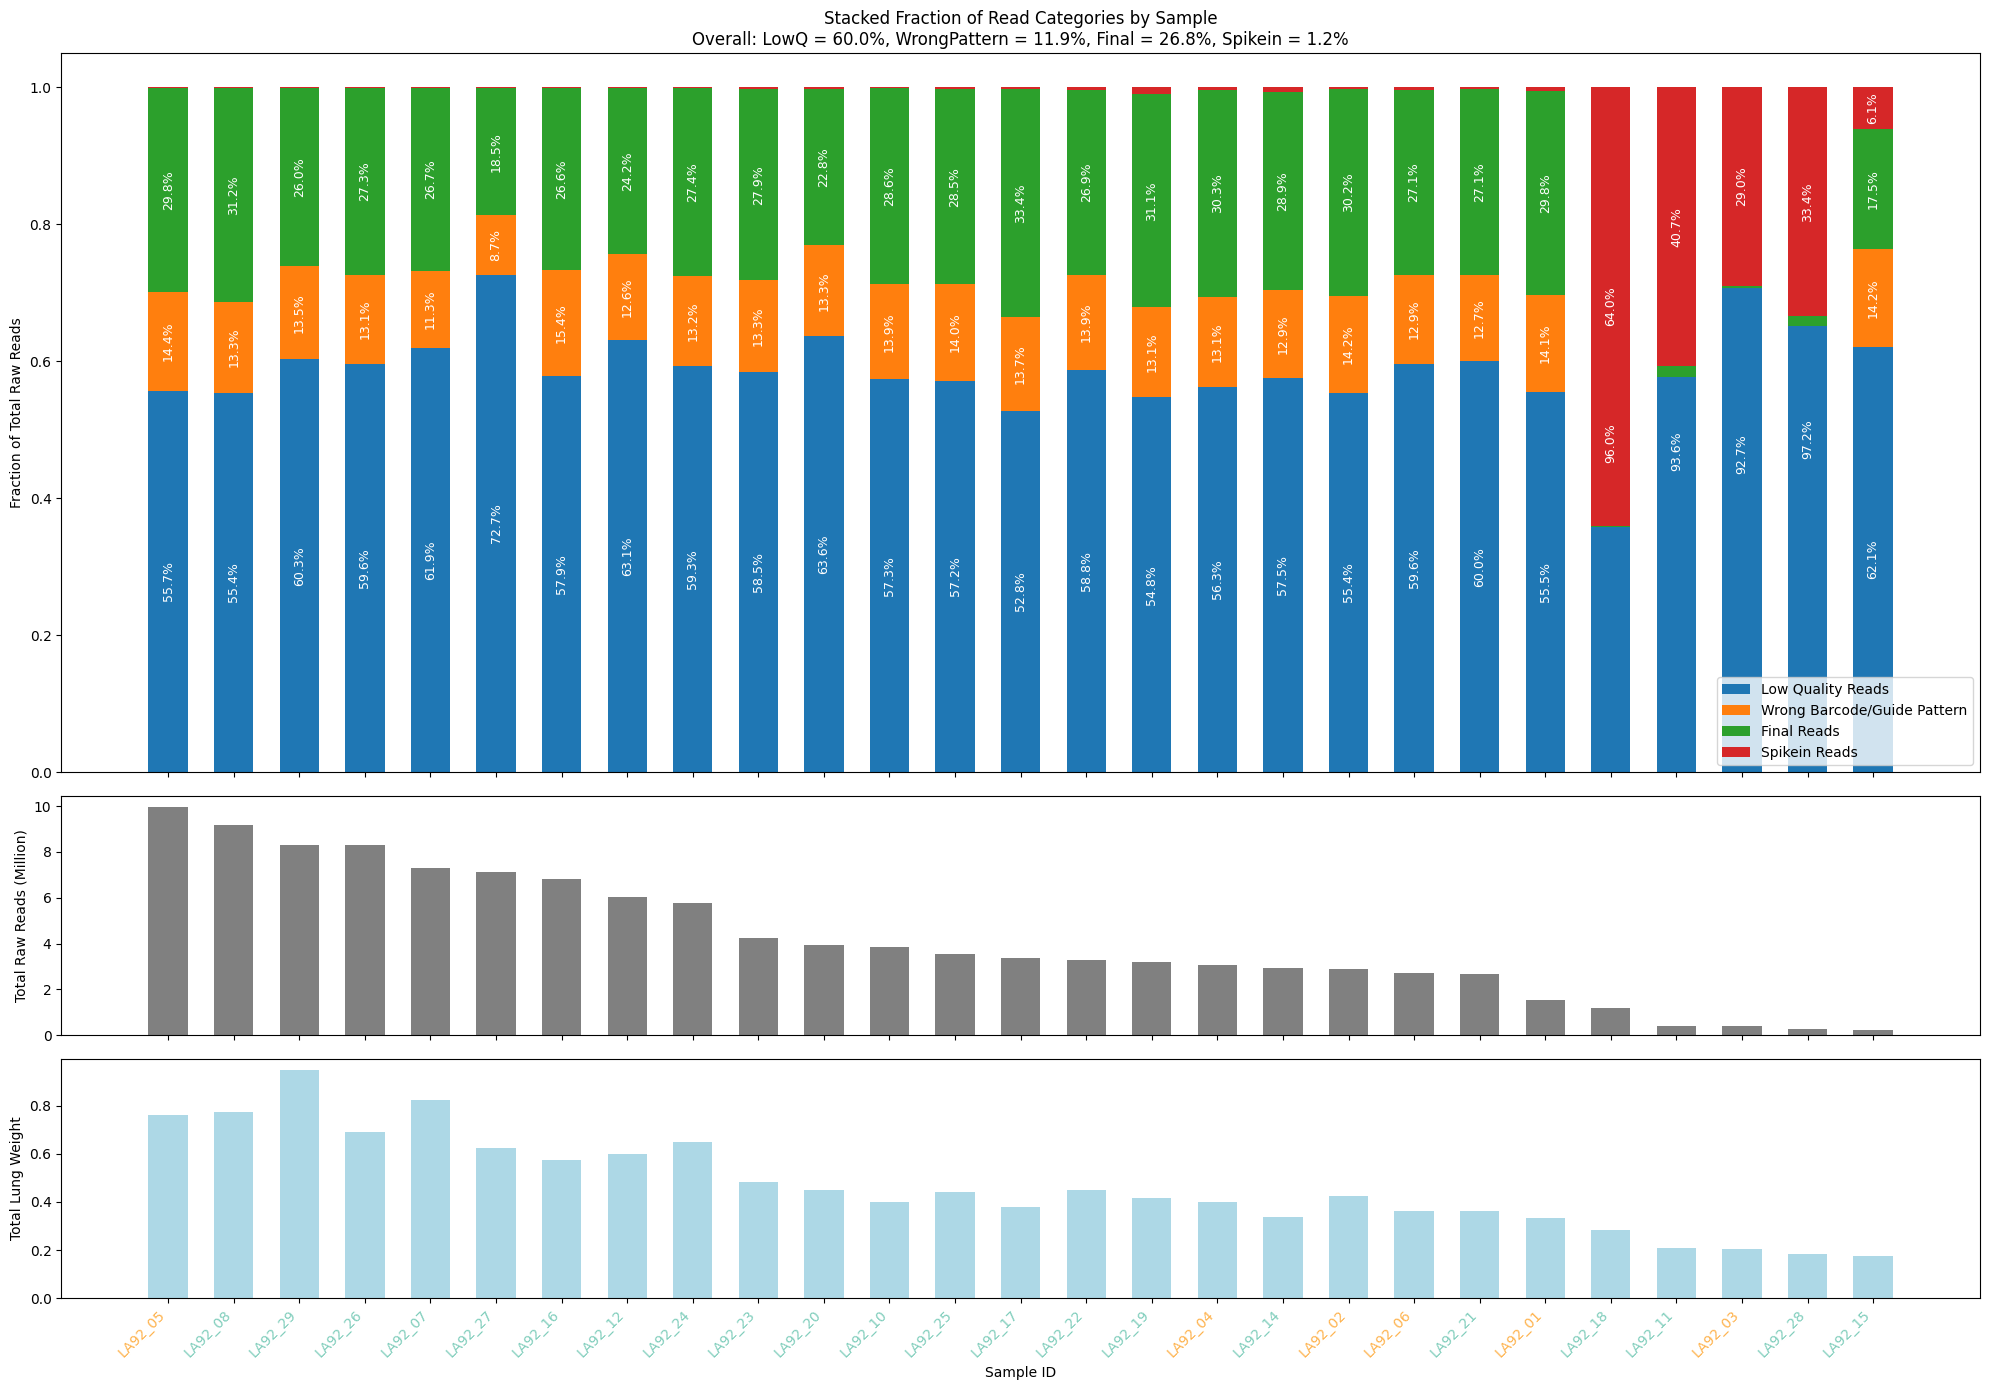

In [41]:
# Sort dataframe by total_raw_reads (descending)
raw_read_input_sorted = read_dist_df.sort_values(by='total_raw_reads', ascending=False).reset_index(drop=True)

# Compute overall totals and fractions
overall_total = raw_read_input_sorted['total_raw_reads'].sum()
overall_lowq = raw_read_input_sorted['lowQ_reads'].sum()
overall_wo_pattern = raw_read_input_sorted['reads_wo_pattern'].sum()
overall_final = raw_read_input_sorted['reads_after_filtering'].sum()
overall_spikein = raw_read_input_sorted['reads_spikein'].sum()

overall_frac_lowq = overall_lowq / overall_total
overall_frac_wo_pattern = overall_wo_pattern / overall_total
overall_frac_final = overall_final / overall_total
overall_frac_spikein = overall_spikein / overall_total

# X positions
x = np.arange(len(raw_read_input_sorted))
bar_width = 0.6

# Fraction arrays
f_lowq = raw_read_input_sorted['frac_lowQ_reads'].values
f_wo_pattern = raw_read_input_sorted['frac_wo_pattern'].values
f_final = raw_read_input_sorted['frac_final'].values
f_spikein = raw_read_input_sorted['frac_spikein'].values

# Define colors based on Mouse_genotype
x_label_colors = [genotype_colors.get(gt, 'gray') for gt in raw_read_input_sorted['Mouse_genotype']]

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 14), gridspec_kw={'height_ratios': [3, 1, 1]}, sharex=True)

# Upper panel: Stacked fraction plot
ax1.bar(x, f_lowq, width=bar_width, label='Low Quality Reads')
ax1.bar(x, f_wo_pattern, width=bar_width, bottom=f_lowq, label='Wrong Barcode/Guide Pattern')
ax1.bar(x, f_final, width=bar_width, bottom=f_lowq + f_wo_pattern, label='Final Reads')
ax1.bar(x, f_spikein, width=bar_width, bottom=f_lowq + f_wo_pattern + f_final, label='Spikein Reads')

# Annotate each segment if its value is significant (>5%)
for i in range(len(x)):
    y_offset = 0
    for val in [f_lowq[i], f_wo_pattern[i], f_final[i], f_spikein[i]]:
        if val > 0.05:
            ax1.text(x[i], y_offset + val / 2, f"{val:.1%}", ha='center', va='center', color='white', fontsize=9, rotation=90)
        y_offset += val

# Axis labels and title for fraction plot
ax1.set_ylabel('Fraction of Total Raw Reads')
ax1.set_title(
    f"Stacked Fraction of Read Categories by Sample\n"
    f"Overall: LowQ = {overall_frac_lowq:.1%}, WrongPattern = {overall_frac_wo_pattern:.1%}, "
    f"Final = {overall_frac_final:.1%}, Spikein = {overall_frac_spikein:.1%}"
)
ax1.legend(loc='lower right')

# Middle panel: Total reads bar plot
ax2.bar(x, raw_read_input_sorted['total_raw_reads'].values / 1e6, width=bar_width, color='gray')
ax2.set_ylabel('Total Raw Reads (Million)')

# Lower panel: Total lung weight
ax3.bar(x, raw_read_input_sorted['Total_lung_weight'].values, width=bar_width, color='lightblue')
ax3.set_ylabel('Total Lung Weight')
ax3.set_xlabel('Sample ID')

# X-axis sample IDs
ax3.set_xticks(x)
ax3.set_xticklabels(raw_read_input_sorted['Sample_ID'], rotation=45, ha='right', color='black')

# Apply genotype-based colors to x-axis labels
for tick_label, color in zip(ax3.get_xticklabels(), x_label_colors):
    tick_label.set_color(color)

plt.tight_layout()

plt.savefig(fig_output_address1, format='pdf')
plt.show()

----

## 4 Spikein QC

### 4.1 Count spikein read numbers and ratio

In [42]:
# I first check if spikes have similar read counts 
spikein_df = Spikein_summary_Cas12a(processed_df,cell_line_number)

In [43]:
spikein_df.head(10)

,Sample_ID,gRNA_combination,Unique_spikein_barcode_number,Count,Spikein_name,Cell_per_read,Amplification
0,LA92_01,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,23,2649,Spikein1,37.750094,115.173913
1,LA92_01,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,18,2576,Spikein2,38.819876,143.111111
2,LA92_01,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA,24,3122,Spikein3,32.030750,130.083333
3,LA92_02,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,14,1516,Spikein1,65.963061,108.285714
4,LA92_02,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,16,1610,Spikein2,62.111801,100.625000
5,LA92_02,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA,18,1942,Spikein3,51.493306,107.888889
6,LA92_03,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,64,33954,Spikein1,2.945161,530.531250
7,LA92_03,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,55,36264,Spikein2,2.757556,659.345455
8,LA92_03,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA,24,41753,Spikein3,2.395037,1739.708333
9,LA92_04,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,21,3382,Spikein1,29.568303,161.047619


In [44]:
# Apply the function to the DataFrame grouped by 'Sample_ID'
spikein_ratio_df = spikein_df.groupby('Sample_ID', as_index=False).apply(cal_spikein_ratio)

In [45]:
spikein_ratio_df.head()

,Sample_ID,Mean_count,s1_s2_ratio,s1_s3_ratio,max_least_ratio,Spikein1,Spikein2,Spikein3
0,LA92_01,2782.333333,1.028339,0.848495,1.211957,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA
1,LA92_02,1689.333333,0.941615,0.780639,1.281003,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA
2,LA92_03,37323.666667,0.936300,0.813211,1.229693,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA
3,LA92_04,3696.666667,0.998524,0.782689,1.277646,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA
4,LA92_05,2267.000000,1.108057,0.993625,1.115166,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA


### 4.2 Find samples with unusual spike in ratio

Text(0, 0.5, 's1/s3')

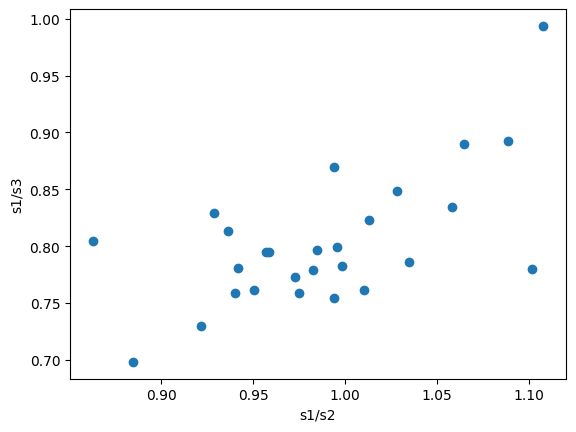

In [46]:
plt.scatter(spikein_ratio_df.s1_s2_ratio,spikein_ratio_df.s1_s3_ratio)
# label_point(spikein_ratio_df.s1_s2_ratio,spikein_ratio_df.s1_s3_ratio, spikein_ratio_df['Sample_ID'], plt.gca())
# plt.xscale('log',base = 2)
# plt.yscale('log',base = 2)
plt.xlabel('s1/s2')
plt.ylabel('s1/s3')

Text(0, 0.5, 's1/s3')

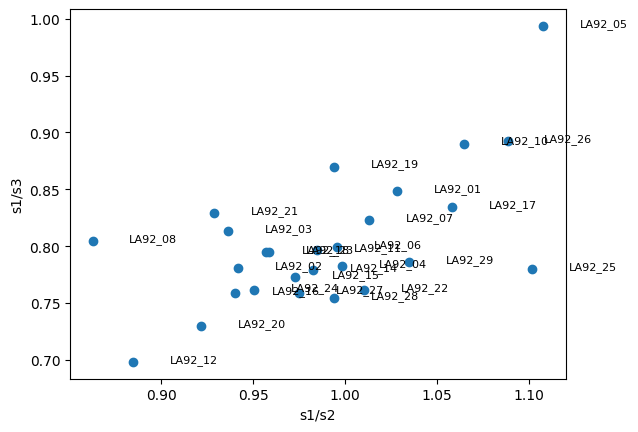

In [47]:
plt.scatter(spikein_ratio_df.s1_s2_ratio,spikein_ratio_df.s1_s3_ratio)
label_point(spikein_ratio_df.s1_s2_ratio,spikein_ratio_df.s1_s3_ratio, spikein_ratio_df['Sample_ID'], plt.gca())
# plt.xscale('log',base = 2)
# plt.yscale('log',base = 2)
plt.xlabel('s1/s2')
plt.ylabel('s1/s3')

<font size="5" color =  black> All good</font>

### 4.3 Find bad spike in for those samples

#### 4.3.1 Method 1

In [48]:
input_ratio_cutoff = 1.4 # this is the cutoff 
temp_bad_list = spikein_ratio_df.loc[spikein_ratio_df['max_least_ratio']>input_ratio_cutoff,'Sample_ID'].to_list() # list of sample with bad spikein

Text(0.5, 0.95, 'Samples with unexpected spike-in ratio (>1.4)')

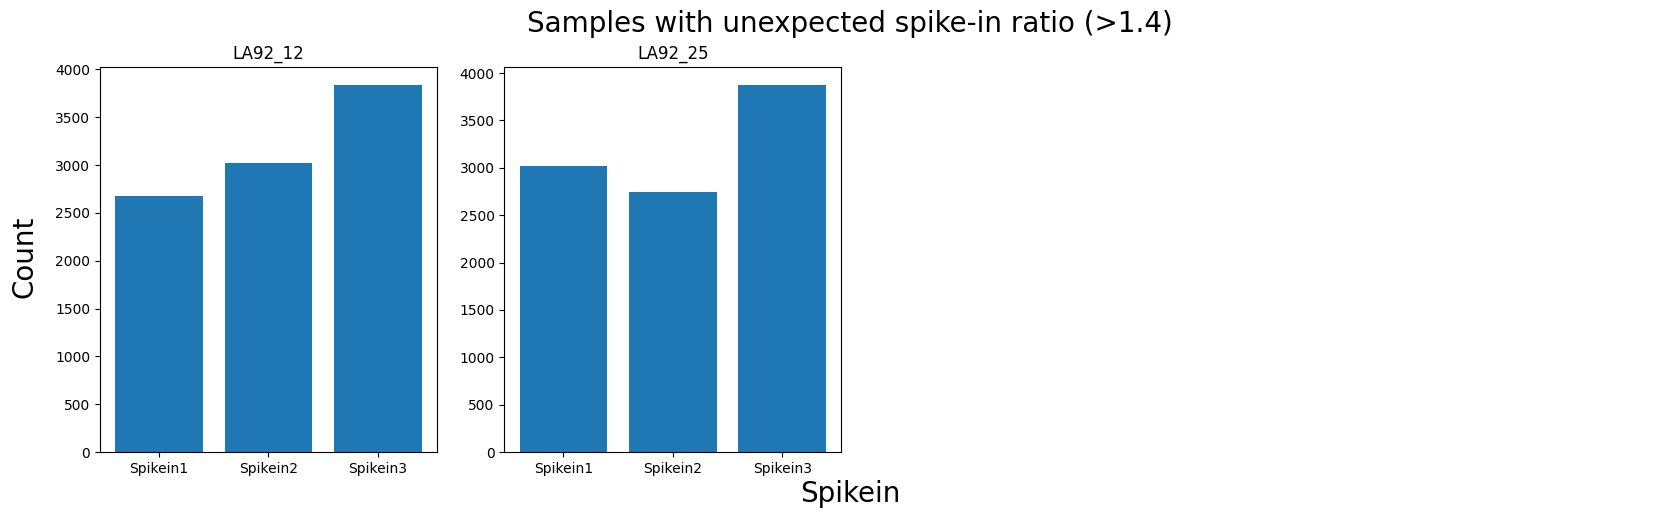

In [49]:
# check the max/min ratio in each sample and print those sample with ratio above certain cutoff
fig1,ax = plt.subplots(math.ceil(len(temp_bad_list)/4), 4, figsize=(20,5*math.ceil(len(temp_bad_list)/4)))
axes = ax.flatten()
for x,y in zip(axes[:len(temp_bad_list)],temp_bad_list):
    temp_df = spikein_df[spikein_df['Sample_ID'] == y]
    x.bar(temp_df['Spikein_name'],temp_df['Count'])
    x.set_title(y)
for x in axes[len(temp_bad_list):]:
    x.set_axis_off()
fig1.text(0.08, 0.5, 'Count', va='center', rotation='vertical',fontsize=20)
fig1.text(0.5, 0.01, 'Spikein', ha='center',fontsize=20)
fig1.text(0.5, 0.95, 'Samples with unexpected spike-in ratio (>{})'.format(input_ratio_cutoff), ha='center',fontsize=20)
# fig1.savefig(figure_output_address+'QC_332.pdf')aa

<font size="5" color =  black> All good</font>

#### 4.3.2 Method 2

In [50]:
def Generate_Simple_Sample_Summary(input_df,input_spikein_df):
    temp_df0 = input_df.groupby(['Sample_ID','Mouse_genotype','Virus_titer','Total_lung_weight'],as_index=False).agg(
        TTR = pd.NamedAgg('Count',aggfunc = sum)) # total reads
    temp_spike_df = input_spikein_df.set_index('Sample_ID')
    temp_df0['Spike1_reads_fraction'] = temp_spike_df[temp_spike_df['Spikein_name']=='Spikein1'].loc[temp_df0.Sample_ID]['Count'].to_list()/temp_df0.TTR
    temp_df0['Spike2_reads_fraction'] = temp_spike_df[temp_spike_df['Spikein_name']=='Spikein2'].loc[temp_df0.Sample_ID]['Count'].to_list()/temp_df0.TTR
    temp_df0['Spike3_reads_fraction'] = temp_spike_df[temp_spike_df['Spikein_name']=='Spikein3'].loc[temp_df0.Sample_ID]['Count'].to_list()/temp_df0.TTR
    return(temp_df0)

In [51]:
temp_summary_df = Generate_Simple_Sample_Summary(processed_df,spikein_df)

In [52]:
temp_summary_df.head()

,Sample_ID,Mouse_genotype,Virus_titer,Total_lung_weight,TTR,Spike1_reads_fraction,Spike2_reads_fraction,Spike3_reads_fraction
0,LA92_01,KT,330000,0.332,462791,0.005724,0.005566,0.006746
1,LA92_02,KT,330000,0.423,882317,0.001718,0.001825,0.002201
2,LA92_03,KT,330000,0.203,112946,0.300622,0.321074,0.369672
3,LA92_04,KT,330000,0.401,941522,0.003592,0.003597,0.004589
4,LA92_05,KT,330000,0.761,2977824,0.000785,0.000709,0.000790


<Axes: xlabel='Mouse_genotype', ylabel='Spike1_reads_fraction'>

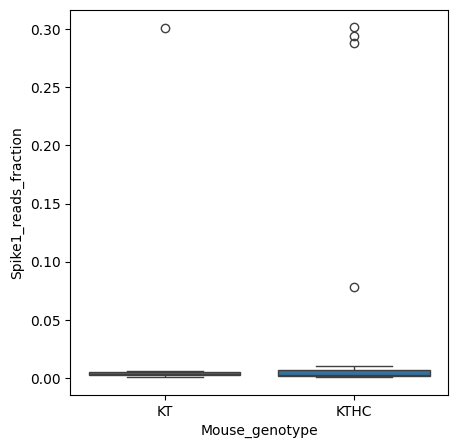

In [53]:
gs = gridspec.GridSpec(1, 17) 
fig1 = plt.figure(figsize=(17,5))
ax1=fig1.add_subplot(gs[:1, 0:5])
temp_df = temp_summary_df
ix = 'Mouse_genotype'
iy = 'Spike1_reads_fraction'
# sns.scatterplot(data=temp_df, x=ix,y =iy ,ax = ax1,hue = 'Pooling_library_name',)
sns.boxplot(data=temp_df, x=ix,y =iy , ax = ax1)
# ax1.set_yscale('log', base=10)

In [54]:
temp_df.groupby('Mouse_genotype', as_index=False)['Spike1_reads_fraction'].mean()

,Mouse_genotype,Spike1_reads_fraction
0,KT,0.052752
1,KTHC,0.048007


In [55]:
temp_df.groupby('Mouse_genotype', as_index=False)['Spike2_reads_fraction'].mean()

,Mouse_genotype,Spike2_reads_fraction
0,KT,0.056144
1,KTHC,0.049085


In [56]:
temp_df.groupby('Mouse_genotype', as_index=False)['Spike3_reads_fraction'].mean()

,Mouse_genotype,Spike3_reads_fraction
0,KT,0.064849
1,KTHC,0.061406


In [57]:
temp_summary_df[['Mouse_genotype']].value_counts()

Mouse_genotype
KTHC              21
KT                 6
Name: count, dtype: int64

In [58]:
temp_summary_df

,Sample_ID,Mouse_genotype,Virus_titer,Total_lung_weight,TTR,Spike1_reads_fraction,Spike2_reads_fraction,Spike3_reads_fraction
0,LA92_01,KT,330000,0.3320,462791,0.005724,0.005566,0.006746
1,LA92_02,KT,330000,0.4230,882317,0.001718,0.001825,0.002201
2,LA92_03,KT,330000,0.2030,112946,0.300622,0.321074,0.369672
3,LA92_04,KT,330000,0.4010,941522,0.003592,0.003597,0.004589
4,LA92_05,KT,330000,0.7610,2977824,0.000785,0.000709,0.000790
5,LA92_06,KT,330000,0.3606,750754,0.004072,0.004091,0.005096
6,LA92_07,KTHC,330000,0.8220,1959397,0.001096,0.001081,0.001331
7,LA92_08,KTHC,330000,0.7730,2867712,0.000683,0.000792,0.000849
8,LA92_10,KTHC,330000,0.4020,1109433,0.001432,0.001345,0.001609
9,LA92_11,KTHC,330000,0.2090,173592,0.293861,0.298349,0.368859


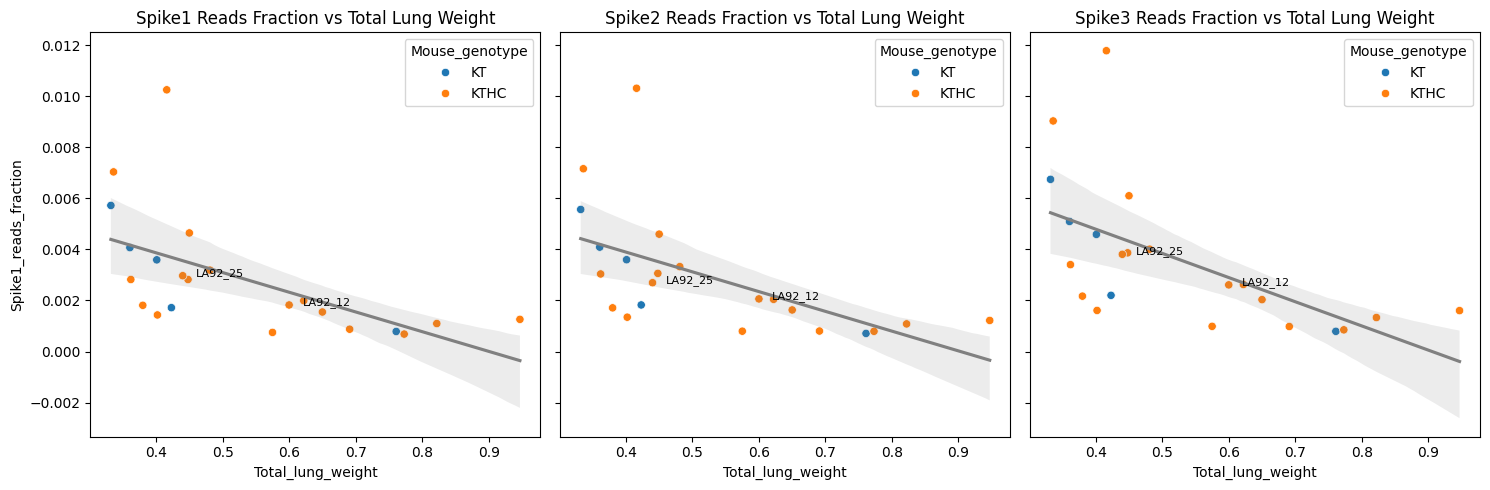

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Set common x-axis label
ix = 'Total_lung_weight'

# Define y-axis values and titles for each subplot
y_axes = ['Spike1_reads_fraction', 'Spike2_reads_fraction', 'Spike3_reads_fraction']
titles = ['Spike1 Reads Fraction vs Total Lung Weight', 'Spike2 Reads Fraction vs Total Lung Weight', 'Spike3 Reads Fraction vs Total Lung Weight']

temp_xlim = (0.1,0.9)
# Iterate through each subplot to plot the data
for ax, iy, title in zip(axes, y_axes, titles):
    temp_df = temp_summary_df[temp_summary_df.Spike1_reads_fraction<0.05]
    
    # Scatter plot for actual data points, hue representing 'Pooling_library_name'
    sns.scatterplot(data=temp_df, x=ix, y=iy,ax=ax, hue = 'Mouse_genotype')
    
    # Linear regression plot (line only)
    sns.regplot(data=temp_df, x=ix, y=iy, ax=ax, scatter=False, line_kws={"color": "grey"})
    
    # Labeling specific points using label_point function
    temp_sub = temp_df[temp_df.Sample_ID.isin(temp_bad_list)]
    label_point(temp_sub[ix], temp_sub[iy], temp_sub['Sample_ID'], ax)
    # ax.set_xlim(temp_xlim)
    # Set the title for each subplot
    ax.set_title(title)

# Improve layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()


----

## 5 Correct cell number

### 5.1 Correct cell number based on spike in 

In [60]:
spikein_ratio_df.sort_values(by='max_least_ratio')

,Sample_ID,Mean_count,s1_s2_ratio,s1_s3_ratio,max_least_ratio,Spikein1,Spikein2,Spikein3
4,LA92_05,2267.000000,1.108057,0.993625,1.115166,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA
16,LA92_19,11077.666667,0.994054,0.869982,1.149449,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA
8,LA92_10,1622.000000,1.065013,0.890196,1.196381,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA
18,LA92_21,2261.333333,0.928539,0.828720,1.206680,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA
0,LA92_01,2782.333333,1.028339,0.848495,1.211957,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA
23,LA92_26,2006.000000,1.088510,0.892294,1.219901,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA
2,LA92_03,37323.666667,0.936300,0.813211,1.229693,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA
6,LA92_07,2291.333333,1.013214,0.823236,1.230769,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA
7,LA92_08,2221.000000,0.862555,0.804107,1.243616,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA
5,LA92_06,3318.000000,0.995441,0.799007,1.251554,ACCTTACAATGTTATATT_ACTAGCAGGTGACACCACCTGCATCA,CCTTGAAATCAAATCAAACC_ACTAGCAGGTGACACCACCTGCATCA,GTGACACTTTCTATTAGGT_ACTAGCAGGTGACACCACCTGCATCA


In [61]:
# temp = [['Spikein1','Spikein3'],['Spikein2','Spikein3'],]
temp = []
conversion_factor_df= Generate_Conversion_factor(spikein_ratio_df,[],temp,cell_line_number)

In [62]:
anotated_df = Final_df_Generation(processed_df,conversion_factor_df)
anotated_df = anotated_df[~anotated_df.gene_combination_unordered.isna()]

### 5.2 Output data

In [63]:
anotated_df.to_parquet(annotated_data_output_address,index =False)

In [64]:
# anotated_df = pd.read_parquet(annotated_data_output_address)

----

## 6 Overall sample QC 

### 6.1 Explaination

* <font size="5"> I only have cutoff for read number >2 and tumor number more than 100 </font>
* <font size="5"> $N_{sgTG_i,S_j}$ Stands for cell number of sgRNAi targeting a certain gene in mouse sample Sj</font>
* <font size="5"> $TTB_{S_j}$ stands for total tumor burden for a sample Sj </font>
* <font size="5"> $TTB_{S_j}=\sum_{i=1}^{n_{S_j}}N_{sgTG_i,S_j}$ </font>
* <font size="5"> When calculating $TTB_{S_j}$, I can also set a cutoff for a minimal cell number to be considered as real epithelial cells </font>

In [65]:
cell_number_cutoff = 300
# use non-spikein data
Sample_summary_df =  Generate_Sample_Summary_Ca12a(anotated_df[anotated_df.Array_category!='Spikein'], spikein_ratio_df,cell_number_cutoff,2)

### 6.2 Output data

In [66]:
Sample_summary_df.to_csv(sample_summary_address, index=False)

In [67]:
Sample_summary_df.head()

,Sample_ID,array_recovered,TTB,TTN,TTB_million,Mouse_genotype,Sex,Time_after_tumor_initiation,Total_lung_weight,Virus_titer,Correction_for_spikein,Cell_number_per_read,TTR,Mean_count,max_least_ratio,Spikein_read_ratio,Tumor number per 100K virus,Total tumor burden (million per 100K virus),TTB_per_mg,Read_cutoff,Cell_number_cutoff
0,LA92_01,376.0,1.473691e+07,4800.0,14.736911,KT,F,16,0.332,330000,No,35.941057,454441,2782.333333,1.211957,0.018036,1454.545455,0.649893,80972.041018,2,300
1,LA92_02,384.0,4.574296e+07,15562.0,45.742956,KT,F,16,0.423,330000,No,59.194949,877249,1689.333333,1.281003,0.005744,4715.757576,1.141810,167556.614656,2,300
2,LA92_03,NaN,NaN,NaN,NaN,KT,F,16,0.203,330000,No,2.679265,975,37323.666667,1.229693,0.991368,NaN,NaN,NaN,2,300
3,LA92_04,374.0,2.209599e+07,4877.0,22.095987,KT,M,16,0.401,330000,No,27.051398,930432,3696.666667,1.277646,0.011779,1477.878788,0.825799,88031.822215,2,300
4,LA92_05,384.0,1.194755e+08,39845.0,119.475518,KT,M,16,0.761,330000,No,44.111160,2971023,2267.000000,1.115166,0.002284,12074.242424,1.558765,195540.946491,2,300


### 6.3 Plotting

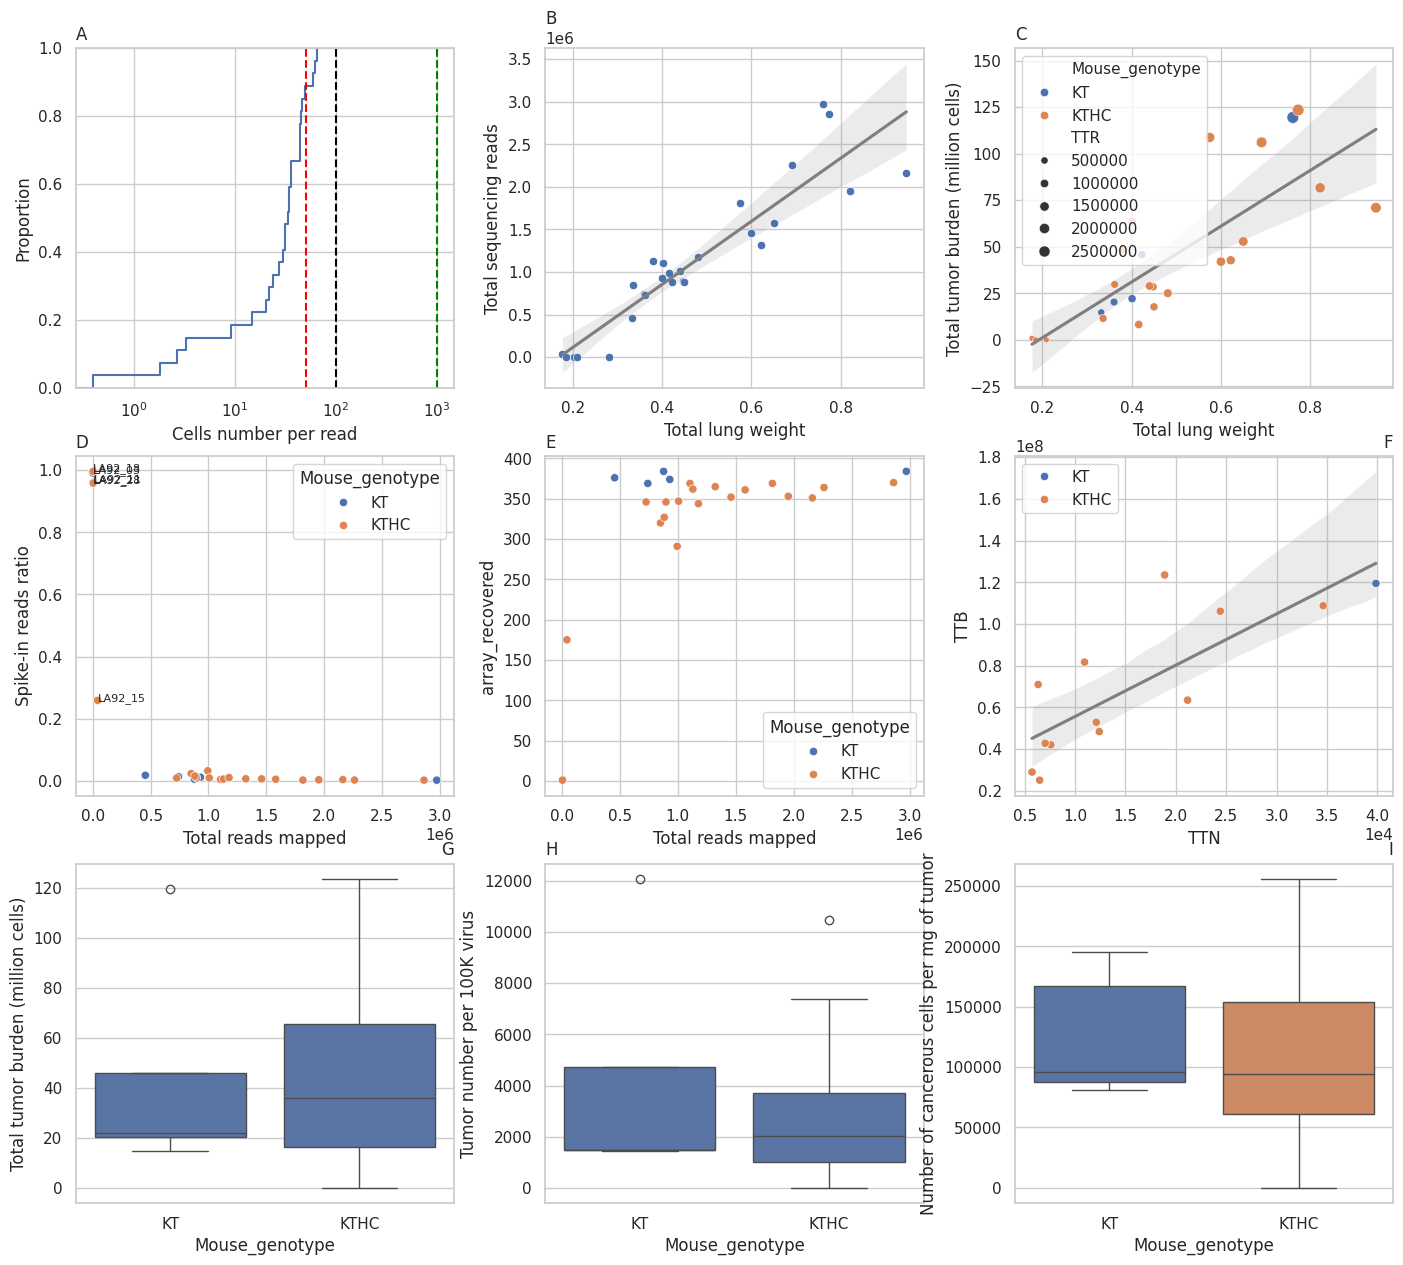

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

# Optional: apply a clean seaborn style
sns.set(style="whitegrid")

# Set up the figure and grid layout
fig1 = plt.figure(figsize=(17, 15))
gs = gridspec.GridSpec(3, 17)

# Panel A: ECDF plot for cell number per read
ax1 = fig1.add_subplot(gs[0, 0:5])
sns.ecdfplot(data=Sample_summary_df, x="Cell_number_per_read", ax=ax1)
ax1.set_xlabel('Cells number per read')
ax1.set_xscale('log')
ax1.axvline(50, color='red', linestyle='--')
ax1.axvline(100, color='black', linestyle='--')
ax1.axvline(1000, color='green', linestyle='--')
ax1.set_title('A', loc='left')

# Panel B: Total lung weight vs TTR
ax2 = fig1.add_subplot(gs[0, 6:11])
sns.regplot(data=Sample_summary_df, x='Total_lung_weight', y='TTR', scatter=False, color='tab:grey', ax=ax2)
sns.scatterplot(data=Sample_summary_df, x='Total_lung_weight', y='TTR', ax=ax2)
ax2.set_xlabel('Total lung weight')
ax2.set_ylabel('Total sequencing reads')
ax2.set_title('B', loc='left')

# Panel C: Total lung weight vs total tumor burden
ax3 = fig1.add_subplot(gs[0, 12:17])
temp_df = Sample_summary_df[
    (Sample_summary_df['Total_lung_weight'] != 0) &
    (~Sample_summary_df['TTB_million'].isna())
]
sns.regplot(data=temp_df, x='Total_lung_weight', y='TTB_million', scatter=False, color='tab:grey', ax=ax3)
sns.scatterplot(data=temp_df, x='Total_lung_weight', y='TTB_million',
                hue='Mouse_genotype', size='TTR', ax=ax3)
ax3.set_xlabel('Total lung weight')
ax3.set_ylabel('Total tumor burden (million cells)')
ax3.set_title('C', loc='left')

# Panel D: TTR vs spike-in read ratio
ax4 = fig1.add_subplot(gs[1, 0:5])
sns.scatterplot(data=Sample_summary_df, x='TTR', y='Spikein_read_ratio',
                hue='Mouse_genotype', ax=ax4)
temp_df = Sample_summary_df[Sample_summary_df.TTR < 100000]
label_point(temp_df['TTR'], temp_df['Spikein_read_ratio'], temp_df['Sample_ID'], ax4)
ax4.set_xlabel('Total reads mapped')
ax4.set_ylabel('Spike-in reads ratio')
ax4.set_title('D', loc='left')

# Panel E: TTR vs array recovery
ax5 = fig1.add_subplot(gs[1, 6:11])
sns.scatterplot(data=Sample_summary_df, x='TTR', y='array_recovered',
                hue='Mouse_genotype', ax=ax5)
temp_df = Sample_summary_df[
    Sample_summary_df.array_recovered < len(anotated_df.gRNA_combination.unique()) * 0.98
]
# label_point(temp_df['TTR'], temp_df['array_recovered'], temp_df['Sample_ID'], ax5)
ax5.set_xlabel('Total reads mapped')
ax5.set_title('E', loc='left')

# Panel F: TTN vs TTB
ax6 = fig1.add_subplot(gs[1, 12:17])
temp_df = Sample_summary_df[Sample_summary_df.TTR > 1_000_000]
sns.regplot(data=temp_df, x='TTN', y='TTB', scatter=False, color='tab:grey', ax=ax6)
sns.scatterplot(data=temp_df, x='TTN', y='TTB', hue='Mouse_genotype', ax=ax6)
ax6.set_xlabel('TTN')
ax6.set_ylabel('TTB')
ax6.ticklabel_format(axis='both', style='sci', scilimits=(-3, 4))
ax6.legend(loc='upper left')
ax6.set_title('F', loc='right')

# Panel G: Boxplot - Mouse genotype vs tumor burden
ax7 = fig1.add_subplot(gs[2, 0:5])
sns.boxplot(data=Sample_summary_df, x='Mouse_genotype', y='TTB_million', ax=ax7)
ax7.set_ylabel('Total tumor burden (million cells)')
ax7.set_title('G', loc='right')

# Panel H: Boxplot - Mouse genotype vs tumor number per 100K virus
ax8 = fig1.add_subplot(gs[2, 6:11])
sns.boxplot(data=Sample_summary_df, x='Mouse_genotype', y='Tumor number per 100K virus', ax=ax8)
ax8.set_ylabel('Tumor number per 100K virus')
ax8.set_title('H', loc='left')

# Panel I: Boxplot - Mouse genotype vs TTB per mg
ax9 = fig1.add_subplot(gs[2, 12:17])
sns.boxplot(data=Sample_summary_df, x='Mouse_genotype', y='TTB_per_mg',
            hue='Mouse_genotype', ax=ax9)
ax9.set_ylabel('Number of cancerous cells per mg of tumor')
ax9.set_title('I', loc='right')

# Optional: save the figure
fig1.savefig(fig_output_address2, dpi=300, bbox_inches='tight')


### 6.4 Nomination sample to exclude

In [69]:
Sample_summary_df.sort_values(by='TTN')

,Sample_ID,array_recovered,TTB,TTN,TTB_million,Mouse_genotype,Sex,Time_after_tumor_initiation,Total_lung_weight,Virus_titer,Correction_for_spikein,Cell_number_per_read,TTR,Mean_count,max_least_ratio,Spikein_read_ratio,Tumor number per 100K virus,Total tumor burden (million per 100K virus),TTB_per_mg,Read_cutoff,Cell_number_cutoff
25,LA92_28,1.0,3.077931e+02,1.0,0.000308,KTHC,M,16,0.1850,330000,No,3.274394,3967,30540.000000,1.326181,0.958499,0.303030,-4.030255,8.794087,2,300
9,LA92_11,2.0,6.113862e+02,2.0,0.000611,KTHC,F,16,0.2090,330000,No,1.798195,6758,55611.333333,1.255214,0.961070,0.606061,-3.732198,10.362477,2,300
12,LA92_15,175.0,7.805587e+05,333.0,0.780559,KTHC,F,16,0.1770,330000,No,20.244281,42374,4939.666667,1.293880,0.259105,100.909091,-0.626108,28909.583043,2,300
16,LA92_19,291.0,8.217949e+06,1542.0,8.217949,KTHC,M,16,0.4160,330000,No,9.027172,993797,11077.666667,1.149449,0.032358,467.272727,0.396250,30894.545213,2,300
11,LA92_14,320.0,1.150223e+07,1999.0,11.502235,KTHC,F,16,0.3360,330000,No,14.833861,850180,6741.333333,1.283709,0.023235,605.757576,0.542268,61839.972948,2,300
19,LA92_22,327.0,1.770977e+07,3720.0,17.709773,KTHC,M,16,0.4500,330000,No,21.815009,882243,4584.000000,1.326862,0.015348,1127.272727,0.729699,59032.577080,2,300
0,LA92_01,376.0,1.473691e+07,4800.0,14.736911,KT,F,16,0.3320,330000,No,35.941057,454441,2782.333333,1.211957,0.018036,1454.545455,0.649893,80972.041018,2,300
3,LA92_04,374.0,2.209599e+07,4877.0,22.095987,KT,M,16,0.4010,330000,No,27.051398,930432,3696.666667,1.277646,0.011779,1477.878788,0.825799,88031.822215,2,300
5,LA92_06,369.0,2.029442e+07,4909.0,20.294424,KT,M,16,0.3606,330000,No,30.138638,740800,3318.000000,1.251554,0.013259,1487.575758,0.788863,96364.787996,2,300
22,LA92_25,347.0,2.893568e+07,5739.0,28.935681,KTHC,M,16,0.4400,330000,No,31.162356,1006414,3209.000000,1.412924,0.009475,1739.090909,0.942920,99778.209991,2,300


In [70]:
Sample_summary_df.sort_values(by='TTN').head(20)

,Sample_ID,array_recovered,TTB,TTN,TTB_million,Mouse_genotype,Sex,Time_after_tumor_initiation,Total_lung_weight,Virus_titer,Correction_for_spikein,Cell_number_per_read,TTR,Mean_count,max_least_ratio,Spikein_read_ratio,Tumor number per 100K virus,Total tumor burden (million per 100K virus),TTB_per_mg,Read_cutoff,Cell_number_cutoff
25,LA92_28,1.0,3.077931e+02,1.0,0.000308,KTHC,M,16,0.1850,330000,No,3.274394,3967,30540.000000,1.326181,0.958499,0.303030,-4.030255,8.794087,2,300
9,LA92_11,2.0,6.113862e+02,2.0,0.000611,KTHC,F,16,0.2090,330000,No,1.798195,6758,55611.333333,1.255214,0.961070,0.606061,-3.732198,10.362477,2,300
12,LA92_15,175.0,7.805587e+05,333.0,0.780559,KTHC,F,16,0.1770,330000,No,20.244281,42374,4939.666667,1.293880,0.259105,100.909091,-0.626108,28909.583043,2,300
16,LA92_19,291.0,8.217949e+06,1542.0,8.217949,KTHC,M,16,0.4160,330000,No,9.027172,993797,11077.666667,1.149449,0.032358,467.272727,0.396250,30894.545213,2,300
11,LA92_14,320.0,1.150223e+07,1999.0,11.502235,KTHC,F,16,0.3360,330000,No,14.833861,850180,6741.333333,1.283709,0.023235,605.757576,0.542268,61839.972948,2,300
19,LA92_22,327.0,1.770977e+07,3720.0,17.709773,KTHC,M,16,0.4500,330000,No,21.815009,882243,4584.000000,1.326862,0.015348,1127.272727,0.729699,59032.577080,2,300
0,LA92_01,376.0,1.473691e+07,4800.0,14.736911,KT,F,16,0.3320,330000,No,35.941057,454441,2782.333333,1.211957,0.018036,1454.545455,0.649893,80972.041018,2,300
3,LA92_04,374.0,2.209599e+07,4877.0,22.095987,KT,M,16,0.4010,330000,No,27.051398,930432,3696.666667,1.277646,0.011779,1477.878788,0.825799,88031.822215,2,300
5,LA92_06,369.0,2.029442e+07,4909.0,20.294424,KT,M,16,0.3606,330000,No,30.138638,740800,3318.000000,1.251554,0.013259,1487.575758,0.788863,96364.787996,2,300
22,LA92_25,347.0,2.893568e+07,5739.0,28.935681,KTHC,M,16,0.4400,330000,No,31.162356,1006414,3209.000000,1.412924,0.009475,1739.090909,0.942920,99778.209991,2,300


In [72]:
f1 = Sample_summary_df[Sample_summary_df['Cell_number_per_read']>200]['Sample_ID'] # read depth
f2 = Sample_summary_df[Sample_summary_df['Spikein_read_ratio']>0.5]['Sample_ID']
f3 = Sample_summary_df[Sample_summary_df['TTR']<20000]['Sample_ID'] # total read depth 

<font size="10" color =  red> I change the criteria of TTR<0.1M to TTR<0.02M just to include more sample </font>

In [73]:
sample_to_throw = list(set(f1)|set(f2)|set(f3))
print(sample_to_throw)

['LA92_18', 'LA92_11', 'LA92_28', 'LA92_03']


In [74]:
Sample_summary_df[Sample_summary_df.Sample_ID.isin(sample_to_throw)]

,Sample_ID,array_recovered,TTB,TTN,TTB_million,Mouse_genotype,Sex,Time_after_tumor_initiation,Total_lung_weight,Virus_titer,Correction_for_spikein,Cell_number_per_read,TTR,Mean_count,max_least_ratio,Spikein_read_ratio,Tumor number per 100K virus,Total tumor burden (million per 100K virus),TTB_per_mg,Read_cutoff,Cell_number_cutoff
2,LA92_03,NaN,NaN,NaN,NaN,KT,F,16,0.203,330000,No,2.679265,975,37323.666667,1.229693,0.991368,NaN,NaN,NaN,2,300
9,LA92_11,2.0,611.386168,2.0,0.000611,KTHC,F,16,0.209,330000,No,1.798195,6758,55611.333333,1.255214,0.961070,0.606061,-3.732198,10.362477,2,300
15,LA92_18,NaN,NaN,NaN,NaN,KTHC,M,16,0.282,330000,No,0.388580,2869,257347.000000,1.258034,0.996298,NaN,NaN,NaN,2,300
25,LA92_28,1.0,307.793058,1.0,0.000308,KTHC,M,16,0.185,330000,No,3.274394,3967,30540.000000,1.326181,0.958499,0.303030,-4.030255,8.794087,2,300


In [75]:
sample_to_throw = ['LA92_03', 'LA92_28', 'LA92_18', 'LA92_11']

In [76]:
print(sample_to_throw)

['LA92_03', 'LA92_28', 'LA92_18', 'LA92_11']


<font size="10" color =  red> 'LA92_03', 'LA92_28', 'LA92_18', 'LA92_11' are excluded because insufficency sequencing </font>

---

## 7 Contamination analysis

### 7.1 Data processing

In [77]:
input_df = anotated_df[anotated_df.Array_category!='Spikein']
input_df = input_df[~input_df.Sample_ID.isin(sample_to_throw)].copy()
input_df = input_df[input_df.Cell_number>50]
input_df['gRNA_clonalbarcode'] = input_df['gRNA_combination'] + '_' + input_df['Clonal_barcode']

In [78]:
temp = input_df.groupby('Sample_ID')['Count'].count()
ref_dict = dict(zip(temp.index, temp.values))

In [79]:
# Step 1: Group by Sample_ID and collect unique gRNA_clonalbarcode values for each Sample_ID
sample_barcodes = input_df.groupby('Sample_ID')['gRNA_clonalbarcode'].apply(set).to_dict()

# Step 2: Get all unique Sample_IDs
sample_ids = list(sample_barcodes.keys())

# Step 3: Initialize an empty DataFrame to store the shared fractions
shared_fraction_df = pd.DataFrame(index=sample_ids, columns=sample_ids)

# Step 4: Calculate the shared fraction of gRNA_clonalbarcode in row Sample_ID (i) with column Sample_ID (j)
for id1 in sample_ids:
    for id2 in sample_ids:
        if id1 == id2:
            shared_fraction_df.loc[id1, id2] = 1.0  # Full overlap with itself
        else:
            # Calculate intersection and the total unique gRNA_clonalbarcode count for Sample_ID id1
            intersection = sample_barcodes[id1].intersection(sample_barcodes[id2])
            shared_fraction = len(intersection) / len(sample_barcodes[id1]) if sample_barcodes[id1] else 0
            shared_fraction_df.loc[id1, id2] = shared_fraction

# Convert all values to numeric
shared_fraction_df = shared_fraction_df.apply(pd.to_numeric)
# Convert the DataFrame to long format
shared_fraction_long_df = shared_fraction_df.reset_index().melt(id_vars='index', var_name='Sample_ID_j', value_name='shared_fraction')
shared_fraction_long_df.rename(columns={'index': 'Sample_ID_i'}, inplace=True)

# Remove rows where Sample_ID_i is equal to Sample_ID_j
# shared_fraction_long_df = shared_fraction_long_df[shared_fraction_long_df['Sample_ID_i'] != shared_fraction_long_df['Sample_ID_j']]
shared_fraction_long_df['Tumor_number_i'] = shared_fraction_long_df.Sample_ID_i.apply(lambda x: ref_dict.get(x))
shared_fraction_long_df['Tumor_number_j'] = shared_fraction_long_df.Sample_ID_j.apply(lambda x: ref_dict.get(x))



### 7.2 Simple relationship

Text(0.4, 0.85, 'P-value = 0.00')

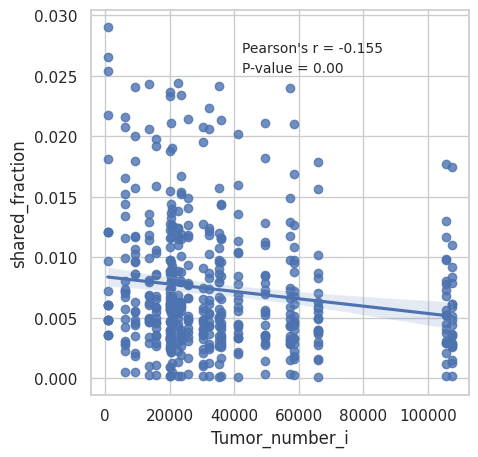

In [80]:
gs = gridspec.GridSpec(5, 17) 
fig1 = plt.figure(figsize=(17,5))


# xtitle = 'Tumor fraction in K mice'
# ytitle = 'sgRNA reads fraction in plasmid library'

ax1=fig1.add_subplot(gs[:5, 0:5])
temp_df = shared_fraction_long_df[shared_fraction_long_df.shared_fraction!=1]
iy = 'shared_fraction'
ix = 'Tumor_number_i'
sns.regplot(x=ix, y=iy, data=temp_df, fit_reg=True ,ax= ax1)

temp1 = scipy.stats.pearsonr(temp_df[ix],temp_df[iy])[0]
temp2 = scipy.stats.pearsonr(temp_df[ix],temp_df[iy])[1]
ax1.text(0.40,0.9, "Pearson's r = "+str(round(temp1,3)), size=10, ha="left",verticalalignment='center', transform=ax1.transAxes)
ax1.text(0.40,0.85, f"P-value = {temp2:.2f}", size=10, ha="left",verticalalignment='center', transform=ax1.transAxes)

Text(0.4, 0.85, 'P-value = 0.00')

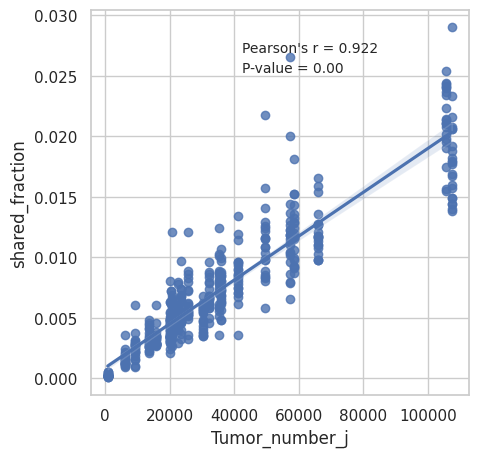

In [81]:
gs = gridspec.GridSpec(5, 17) 
fig1 = plt.figure(figsize=(17,5))


# xtitle = 'Tumor fraction in K mice'
# ytitle = 'sgRNA reads fraction in plasmid library'

ax1=fig1.add_subplot(gs[:5, 0:5])
temp_df = shared_fraction_long_df[shared_fraction_long_df.shared_fraction!=1]
iy = 'shared_fraction'
ix = 'Tumor_number_j'
sns.regplot(x=ix, y=iy, data=temp_df, fit_reg=True ,ax= ax1)

temp1 = scipy.stats.pearsonr(temp_df[ix],temp_df[iy])[0]
temp2 = scipy.stats.pearsonr(temp_df[ix],temp_df[iy])[1]
ax1.text(0.40,0.9, "Pearson's r = "+str(round(temp1,3)), size=10, ha="left",verticalalignment='center', transform=ax1.transAxes)
ax1.text(0.40,0.85, f"P-value = {temp2:.2f}", size=10, ha="left",verticalalignment='center', transform=ax1.transAxes)

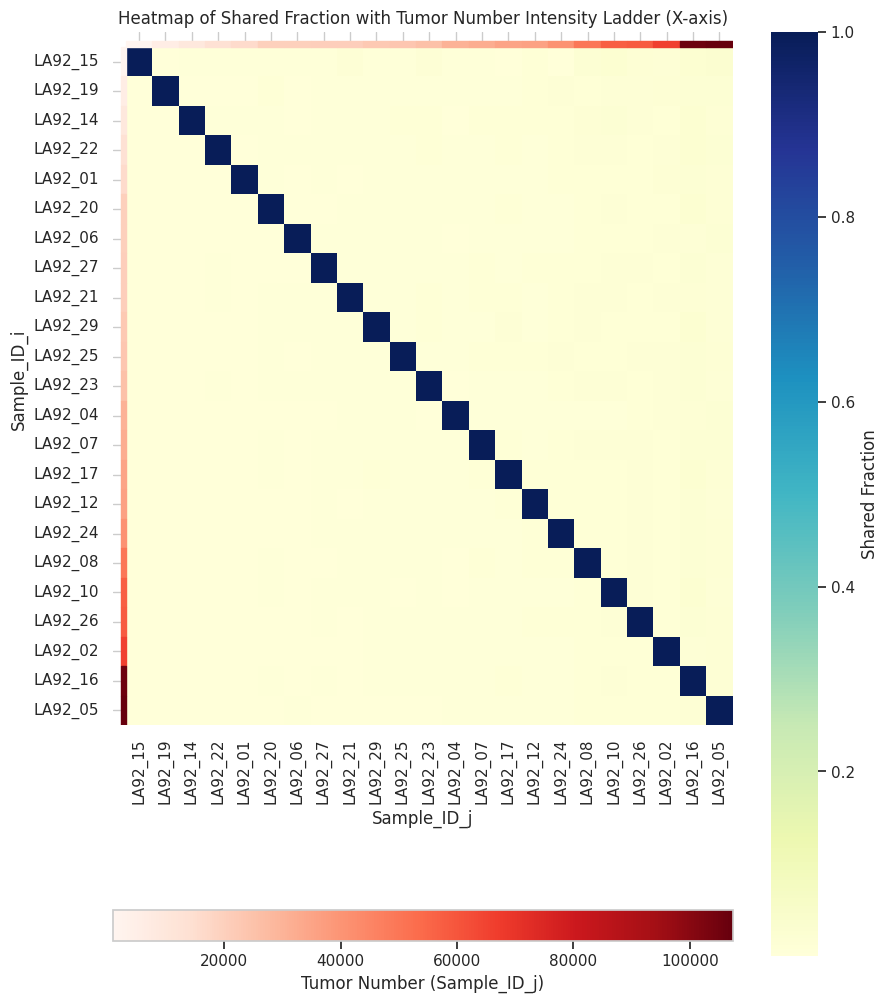

In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sort the DataFrame by Tumor_number_i and Tumor_number_j
sorted_df = shared_fraction_long_df.sort_values(['Tumor_number_i', 'Tumor_number_j'])

# Create a pivot table for the heatmap, sorted by Sample_IDs
heatmap_data = sorted_df.pivot(index='Sample_ID_i', columns='Sample_ID_j', values='shared_fraction')

# Ensure rows and columns are sorted based on Tumor_number
heatmap_data = heatmap_data.loc[sorted_df['Sample_ID_i'].unique(), sorted_df['Sample_ID_j'].unique()]

# Extract Tumor_number_i and Tumor_number_j values in the order of sorted Sample_IDs
tumor_number_i = sorted_df.drop_duplicates('Sample_ID_i').set_index('Sample_ID_i')['Tumor_number_i']
tumor_number_j = sorted_df.drop_duplicates('Sample_ID_j').set_index('Sample_ID_j')['Tumor_number_j']

# Plot the main heatmap
fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(
    heatmap_data, cmap='YlGnBu', cbar_kws={'label': 'Shared Fraction'},
    ax=ax, xticklabels=True, yticklabels=True
)
# Create colorbars (ladders) for Tumor_number_i (y-axis) and Tumor_number_j (x-axis)
# Normalize the tumor numbers for consistent color mapping
norm_i = plt.Normalize(tumor_number_i.min(), tumor_number_i.max())
norm_j = plt.Normalize(tumor_number_j.min(), tumor_number_j.max())
cmap_i = plt.cm.Reds
cmap_j = plt.cm.Reds

# Adjust thickness for ladders (0.3 width for y-axis ladder, 0.3 height for x-axis ladder)
ladder_thickness_y = 0.2
ladder_thickness_x = 0.2

# Add the ladder for Tumor_number_i on the left side
for i, value in enumerate(tumor_number_i):
    ax.add_patch(plt.Rectangle((-ladder_thickness_y, i), ladder_thickness_y, 1, color=cmap_i(norm_i(value))))

# Add the ladder for Tumor_number_j on the top
for j, value in enumerate(tumor_number_j):
    ax.add_patch(plt.Rectangle((j, -ladder_thickness_x), 1, ladder_thickness_x, color=cmap_j(norm_j(value))))

# Adjust plot limits to make space for the x-axis ladder
ax.set_ylim(len(heatmap_data), -0.5)
ax.set_xlim(-0.5, len(tumor_number_j))

# Add a color bar for the x-axis ladder legend
sm = plt.cm.ScalarMappable(cmap=cmap_j, norm=norm_j)
sm.set_array([])  # We don't actually need data here
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.2, fraction=0.05)
cbar.set_label('Tumor Number (Sample_ID_j)')

# Show plot
plt.title("Heatmap of Shared Fraction with Tumor Number Intensity Ladder (X-axis)")
plt.show()


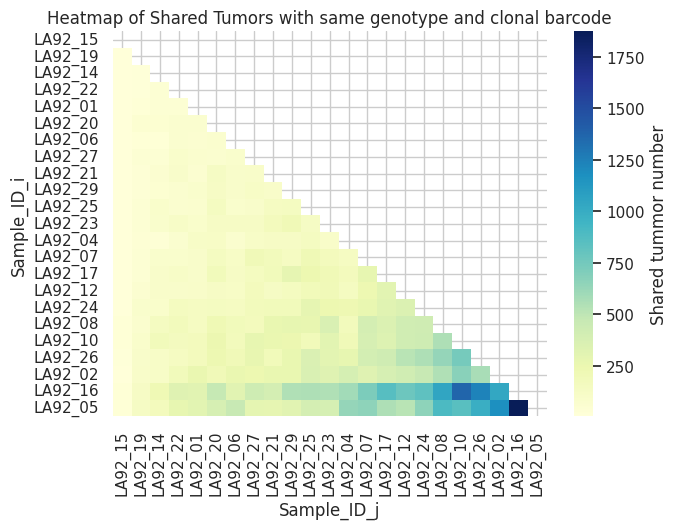

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sort the DataFrame by Tumor_number_i and Tumor_number_j
sorted_df = shared_fraction_long_df.sort_values(['Tumor_number_i', 'Tumor_number_j']).copy()
sorted_df['Shared_tummor'] = sorted_df['shared_fraction'] * sorted_df['Tumor_number_i']

# Create a pivot table for the heatmap, sorted by Sample_IDs
heatmap_data = sorted_df.pivot(index='Sample_ID_i', columns='Sample_ID_j', values='Shared_tummor')

# Ensure rows and columns are sorted based on Tumor_number
heatmap_data = heatmap_data.loc[sorted_df['Sample_ID_i'].unique(), sorted_df['Sample_ID_j'].unique()]

# Extract Tumor_number_i and Tumor_number_j values in the order of sorted Sample_IDs
tumor_number_i = sorted_df.drop_duplicates('Sample_ID_i').set_index('Sample_ID_i')['Tumor_number_i']
tumor_number_j = sorted_df.drop_duplicates('Sample_ID_j').set_index('Sample_ID_j')['Tumor_number_j']

# Mask the upper triangle of the heatmap (only show lower triangle)
mask = np.triu(np.ones(heatmap_data.shape, dtype=bool))

# Plot the main heatmap
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(
    heatmap_data, mask=mask, cmap='YlGnBu', cbar_kws={'label': 'Shared tummor number'},
    ax=ax, xticklabels=True, yticklabels=True
)


# Show plot
plt.title("Heatmap of Shared Tumors with same genotype and clonal barcode")
plt.show()
# fig.savefig(temp_out_address4_1)


/home/xhq/miniconda3/envs/UltraSeq/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


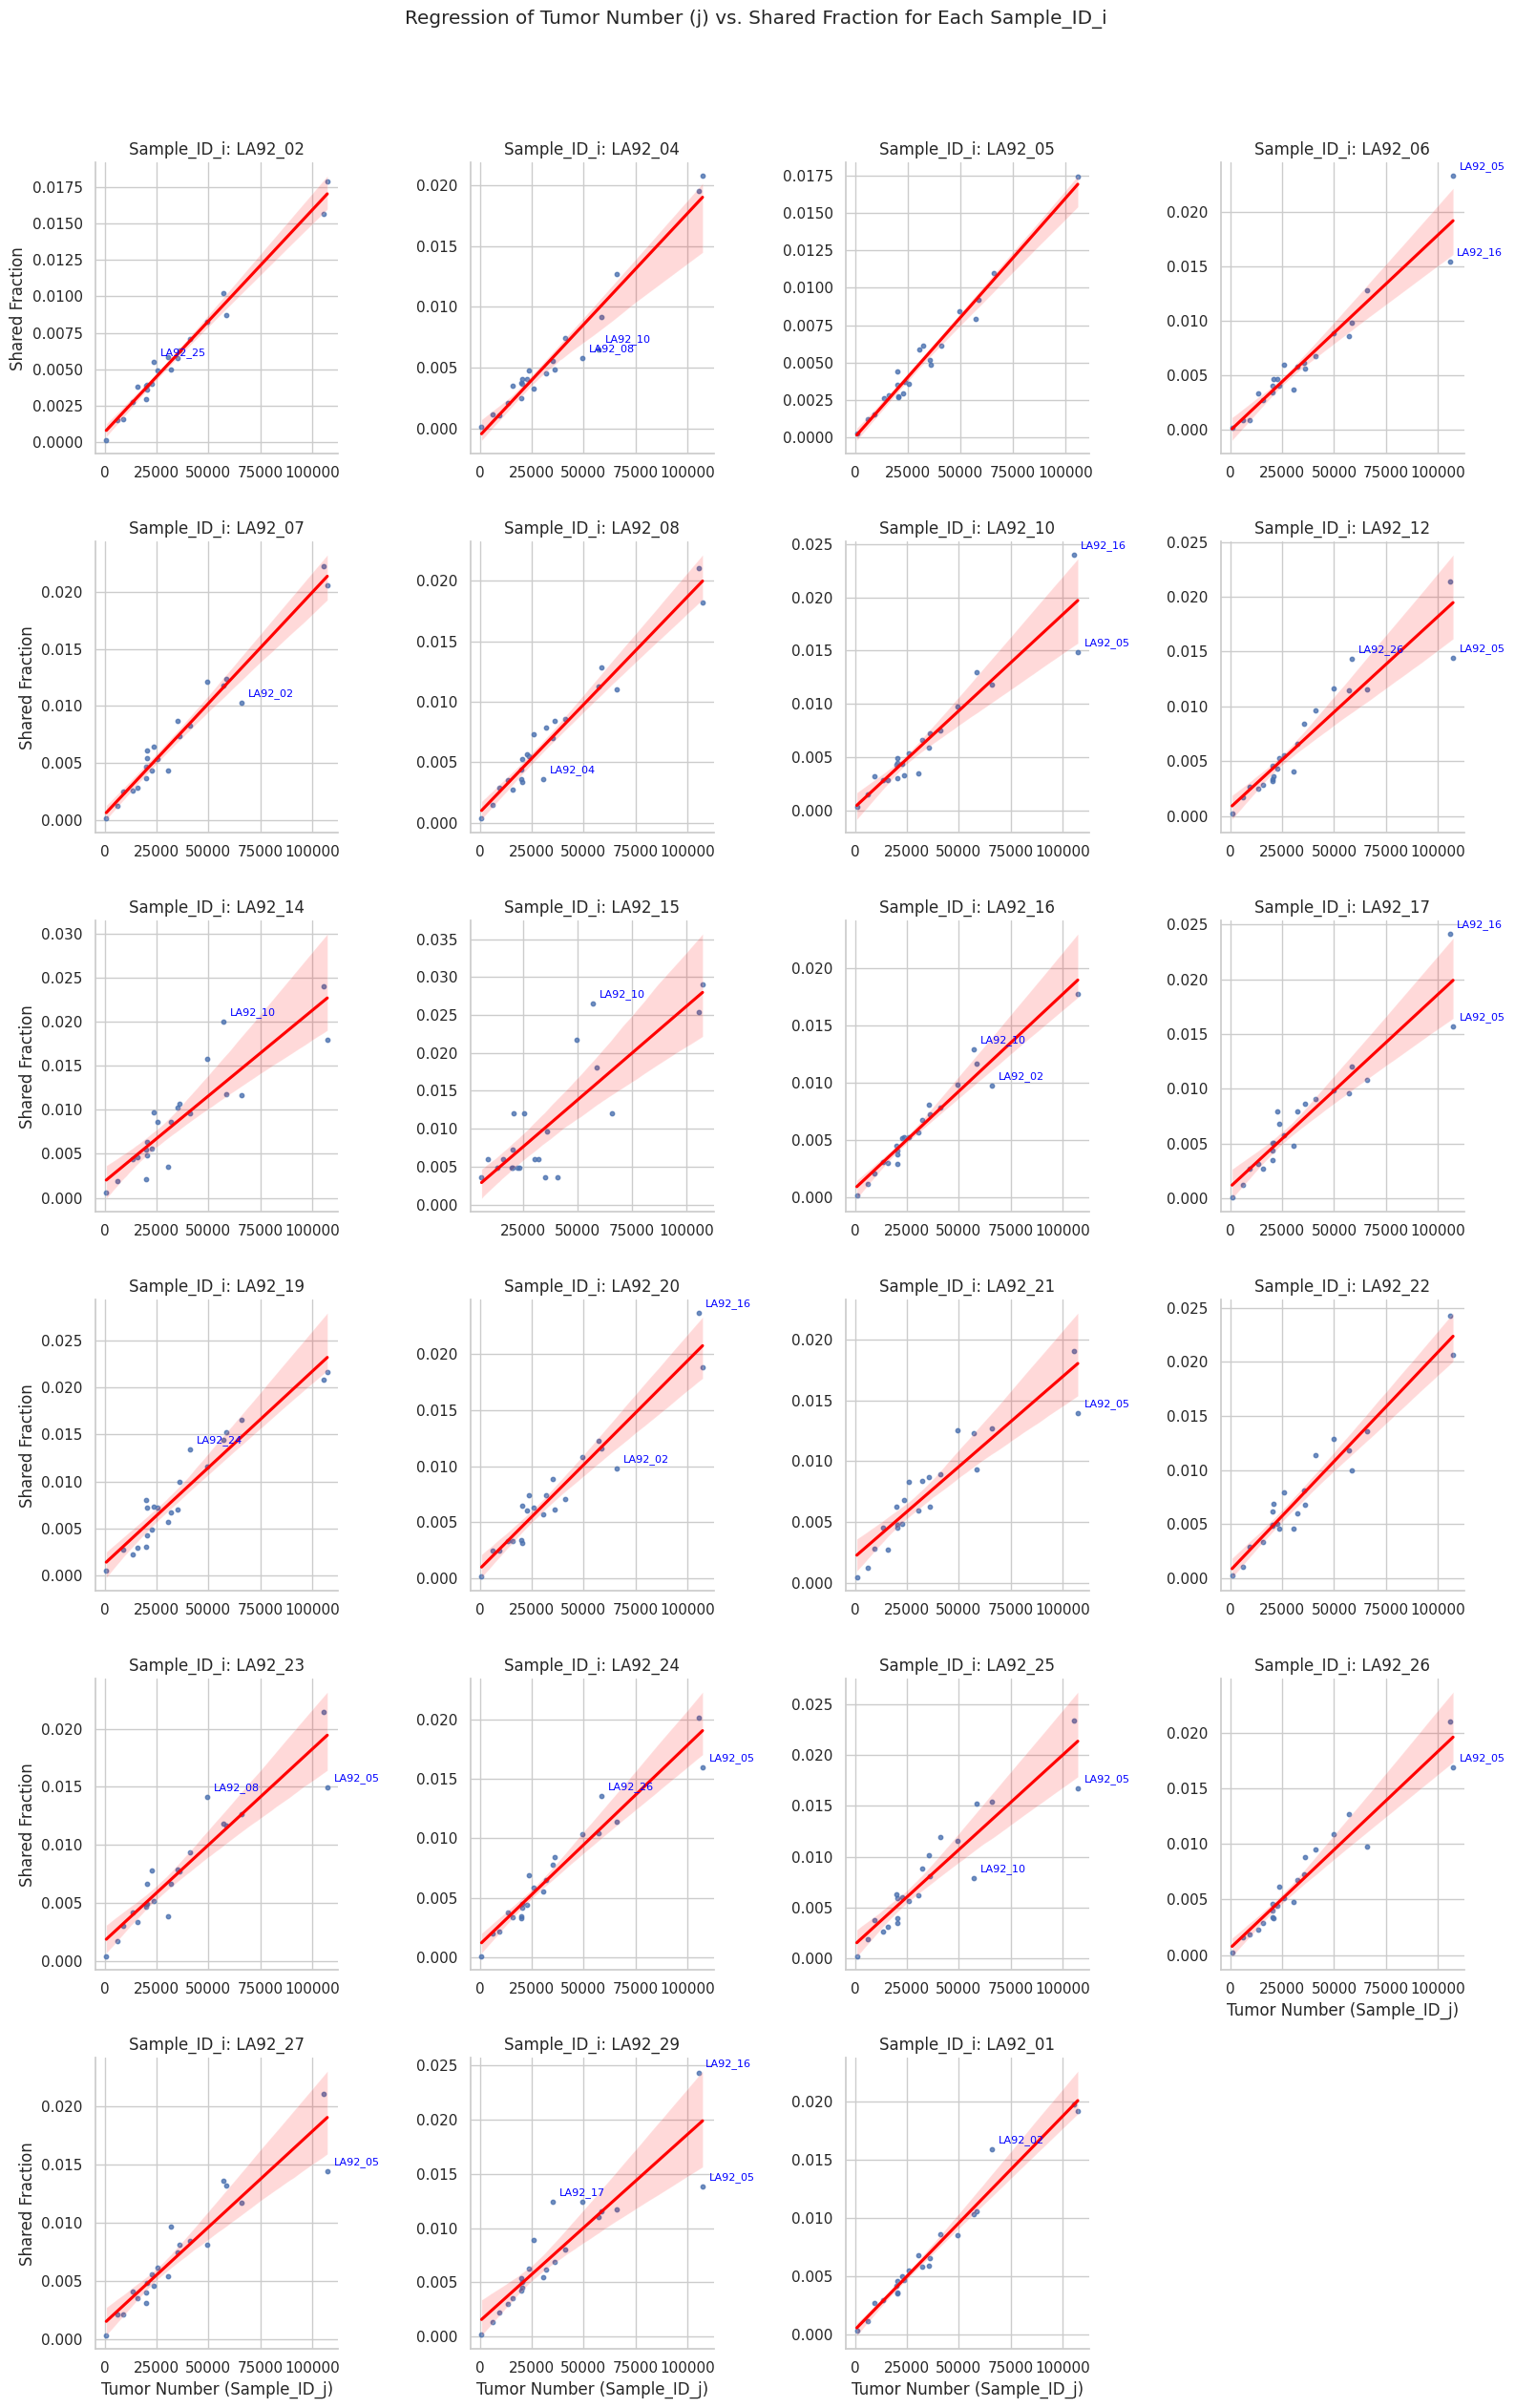

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Filter the data as in your original code
query_df = shared_fraction_long_df[shared_fraction_long_df['Sample_ID_i'] != shared_fraction_long_df['Sample_ID_j']]

# Define a function to plot and annotate outliers
def annotate_outliers(data, **kwargs):
    ax = plt.gca()
    
    # Scatter plot and regression line
    sns.regplot(x="Tumor_number_j", y="shared_fraction", data=data, ax=ax, 
                scatter_kws={'s': 10}, line_kws={'color': 'red'})
    
    # Fit a regression model
    X = data["Tumor_number_j"].values.reshape(-1, 1)
    y = data["shared_fraction"].values
    reg = LinearRegression().fit(X, y)
    predictions = reg.predict(X)
    
    # Calculate residuals and standard deviation of residuals
    residuals = y - predictions
    std_residuals = np.std(residuals)
    
    # Identify points beyond confidence interval (±2 standard deviations)
    outliers = np.abs(residuals) > 2 * std_residuals
    outlier_points = data[outliers]
    
    # Annotate outliers with Sample_ID_i
    for _, row in outlier_points.iterrows():
        ax.annotate(row['Sample_ID_j'], (row['Tumor_number_j'], row['shared_fraction']), 
                    textcoords="offset points", xytext=(5, 5), ha='left', fontsize=8, color='blue')

# Set up the FacetGrid to create a separate plot for each Sample_ID_i
g = sns.FacetGrid(query_df, col="Sample_ID_i", col_wrap=4, height=4, sharex=False, sharey=False)

# Apply the custom function to each facet
g.map_dataframe(annotate_outliers)

# Adjust labels and titles
g.set_axis_labels("Tumor Number (Sample_ID_j)", "Shared Fraction")
g.set_titles("Sample_ID_i: {col_name}")
g.fig.suptitle("Regression of Tumor Number (j) vs. Shared Fraction for Each Sample_ID_i", y=1.05)

# Show plot
plt.show()


### 7.3 quadratic fit

Regression Coefficients:
Tumor_number_j coefficient: 0.0002
Tumor_number_i coefficient: 0.0006
Interaction term coefficient: 0.0000
Intercept: 9.9369


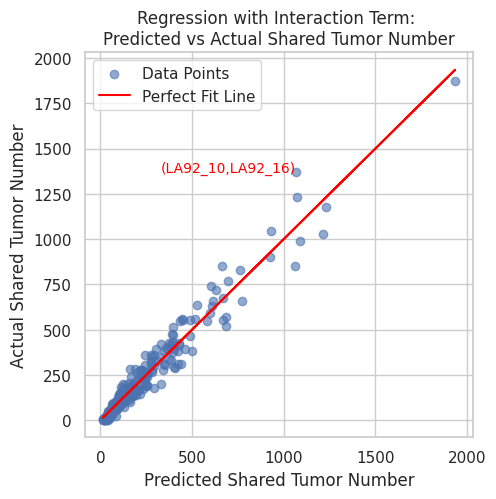

10-Fold Cross-Validation MSE: 4186.6667 ± 3066.9938
10-Fold Cross-Validation R^2: 0.9134 ± 0.0383


In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np

# Prepare the data for regression
# Calculate shared tumor and filter out diagonal comparisons
query_df = shared_fraction_long_df.copy()
query_df['Shared_tummor'] = query_df['shared_fraction'] * query_df['Tumor_number_i']
query_df = query_df[query_df['Sample_ID_i'] != query_df['Sample_ID_j']]

# Eliminate reciprocal cases
query_df[['Sample_ID_i', 'Sample_ID_j']] = np.sort(query_df[['Sample_ID_i', 'Sample_ID_j']].values, axis=1)
query_df = query_df.drop_duplicates(subset=['Sample_ID_i', 'Sample_ID_j'])

# Remove missing values and reset the index
df = query_df.dropna().reset_index()

# Define independent variables (Tumor_number_i, Tumor_number_j) and target (Shared_tummor)
X = df[['Tumor_number_j', 'Tumor_number_i']].copy()  # Make a copy to avoid SettingWithCopyWarning
y = df['Shared_tummor']

# Add interaction term (Tumor_number_j * Tumor_number_i)
X['Interaction'] = X['Tumor_number_j'] * X['Tumor_number_i']


# Fit the multiple linear regression model with interaction term
model = LinearRegression()
model.fit(X, y)

# Get predictions and residuals
predicted = model.predict(X)
residuals = y - predicted

# Determine threshold for outliers (e.g., 3 standard deviations from the mean residual)
threshold = 5 * np.std(residuals)

# Identify outliers
outliers = df[np.abs(residuals) > threshold].copy()
outliers['Predicted_shared_tumor'] = predicted[outliers.index]

# Print regression coefficients for interpretation
print("Regression Coefficients:")
print(f"Tumor_number_j coefficient: {model.coef_[0]:.4f}")
print(f"Tumor_number_i coefficient: {model.coef_[1]:.4f}")
print(f"Interaction term coefficient: {model.coef_[2]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

# Scatter plot: Predicted vs Actual Shared Tumor Number
plt.figure(figsize=(5, 5))
plt.scatter(predicted, y, label="Data Points", alpha=0.6)
plt.plot(predicted, predicted, color="red", label="Perfect Fit Line")

# Label outliers with Sample_ID pairs (i, j)
for _, row in outliers.iterrows():
    ti = row["Sample_ID_i"]
    tj = row["Sample_ID_j"]
    plt.text(predicted[row.name], row["Shared_tummor"], f"({ti},{tj})", fontsize=10, color="red", ha="right")

# Plot settings
plt.xlabel("Predicted Shared Tumor Number")
plt.ylabel("Actual Shared Tumor Number")
plt.title("Regression with Interaction Term: \nPredicted vs Actual Shared Tumor Number")
plt.legend()
# plt.savefig(temp_out_address4_2)
plt.show()

# Define scoring functions for cross-validation
scoring = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': make_scorer(r2_score)
}

# Perform 10-fold cross-validation
cv_results = cross_validate(model, X, y, scoring=scoring, cv=10)

# Calculate mean and standard deviation of cross-validation MSE and R^2 scores
mean_mse = -cv_results['test_MSE'].mean()  # Convert negative MSE back to positive
std_mse = cv_results['test_MSE'].std()
mean_r2 = cv_results['test_R2'].mean()
std_r2 = cv_results['test_R2'].std()

# Print cross-validation results
print(f"10-Fold Cross-Validation MSE: {mean_mse:.4f} ± {std_mse:.4f}")
print(f"10-Fold Cross-Validation R^2: {mean_r2:.4f} ± {std_r2:.4f}")


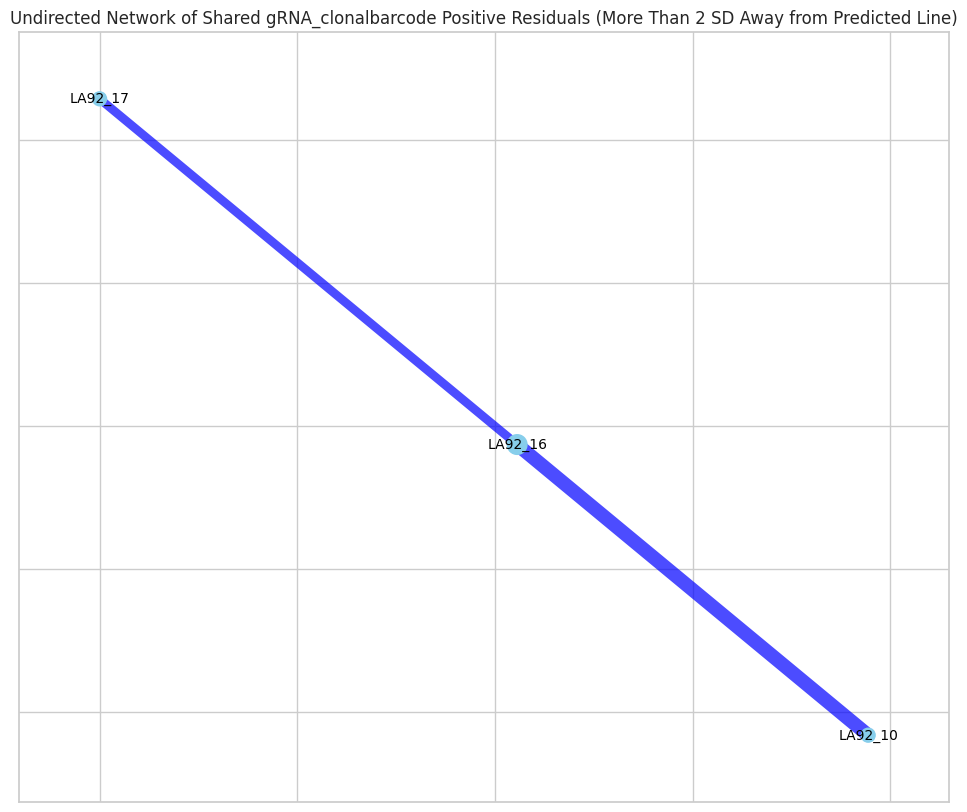

In [86]:
import networkx as nx
from sklearn.linear_model import LinearRegression

# Assuming shared_fraction_long_df is already defined in the environment
query_df = shared_fraction_long_df.copy()
query_df['Shared_tummor'] = query_df['shared_fraction'] * query_df['Tumor_number_i']
query_df = query_df[query_df['Sample_ID_i'] != query_df['Sample_ID_j']]

# Eliminate reciprocal cases
query_df[['Sample_ID_i', 'Sample_ID_j']] = np.sort(query_df[['Sample_ID_i', 'Sample_ID_j']].values, axis=1)
query_df = query_df.drop_duplicates(subset=['Sample_ID_i', 'Sample_ID_j'])

# Remove missing values and reset the index
df = query_df.dropna().reset_index()

# Define independent variables (Tumor_number_i, Tumor_number_j) and target (Shared_tummor)
X = df[['Tumor_number_j', 'Tumor_number_i']].copy()  # Make a copy to avoid SettingWithCopyWarning
y = df['Shared_tummor']

# Add interaction term (Tumor_number_j * Tumor_number_i)
X['Interaction'] = X['Tumor_number_j'] * X['Tumor_number_i']

# Fit the linear Regressor model
model = LinearRegression()
model.fit(X, y)

# Get predictions and residuals
predicted = model.predict(X)
residuals = y - predicted

df['residual'] = residuals

# Calculate mean and standard deviation of residuals
mean_residual = df['residual'].mean()
std_residual = df['residual'].std()

# Define the threshold for filtering (2 standard deviations from the predicted line)
threshold = 3 * std_residual

# Filter DataFrame for positive residuals more than 2 standard deviations away from the predicted line
filtered_df_positive = df[df['residual'] > threshold]

# Initialize an undirected graph
G = nx.Graph()

# Add edges with weights for pairs that meet the positive threshold
for _, row in filtered_df_positive.iterrows():
    G.add_edge(row['Sample_ID_i'], row['Sample_ID_j'], weight=row['residual'], color='blue')

# Plot the undirected network graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G)  # Use spring layout for visual appeal

# Normalize edge weights for visualization
max_weight = max([data['weight'] for _, _, data in G.edges(data=True)]) if len(G.edges()) > 0 else 1
weights = [G[u][v]['weight'] / max_weight * 10 for u, v in G.edges()]  # Scale weights to a range (0-10)

# Draw nodes with size based on degree
node_sizes = [G.degree(node) * 100 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=node_sizes)

# Draw undirected edges with color for positive residuals
edge_colors = [G[u][v]['color'] for u, v in G.edges()]
nx.draw_networkx_edges(
    G, pos, edgelist=G.edges(), width=weights, alpha=0.7, edge_color=edge_colors
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

# Title and show plot
plt.title("Undirected Network of Shared gRNA_clonalbarcode Positive Residuals (More Than 2 SD Away from Predicted Line)")
plt.show()


In [87]:
filtered_df_positive.sort_values(by='residual')

,index,Sample_ID_i,Sample_ID_j,shared_fraction,Tumor_number_i,Tumor_number_j,Shared_tummor,residual
187,265,LA92_16,LA92_17,0.024134,35345,105707,853.0,191.616553
136,172,LA92_10,LA92_16,0.012970,105707,57190,1371.0,306.397864


### 7.4 Examples 1

In [88]:
test_sample = ['LA92_16','LA92_17']
query_df = input_df[input_df.Sample_ID.isin(test_sample)].copy()
query_df['Log10CN'] = np.log10(query_df['Cell_number'])
temp = pd.pivot_table(query_df, values = 'Log10CN', index=['gRNA_clonalbarcode','gRNA_combination'], columns = 'Sample_ID').reset_index()
re_shaped_df = temp[~temp.isnull().any(axis=1)]

In [89]:
df1 = query_df[query_df.Sample_ID==test_sample[0]].copy()
df2 = query_df[query_df.Sample_ID==test_sample[1]].copy()
df1['Kind'] = 'Unique'
df1.loc[df1.gRNA_clonalbarcode.isin(df2.gRNA_clonalbarcode),'Kind']='Shared'

df2['Kind'] = 'Unique'
df2.loc[df2.gRNA_clonalbarcode.isin(df1.gRNA_clonalbarcode),'Kind']='Shared'

/home/xhq/miniconda3/envs/UltraSeq/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


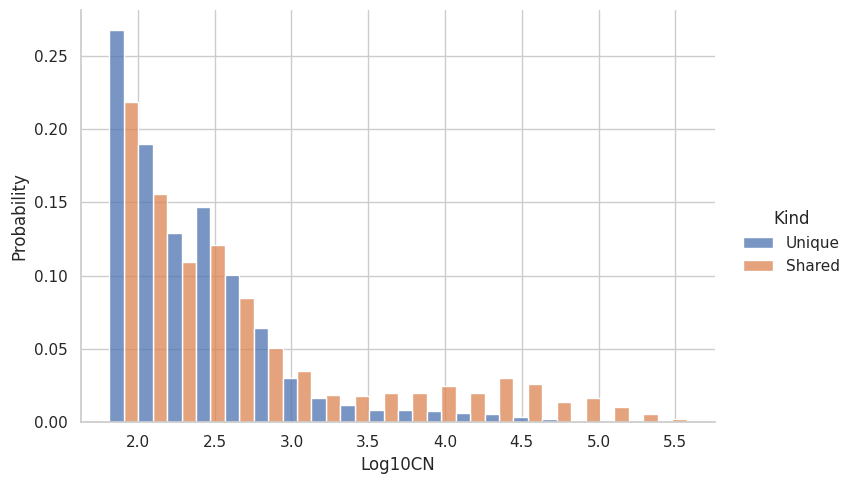

In [90]:
temp_df = df1.copy()
ax = sns.displot(data=temp_df, x="Log10CN", kind="hist", bins = 20,hue = 'Kind',
                 common_norm = False, aspect = 1.5,log_scale = [False,False],stat='probability',multiple = 'dodge' )

/home/xhq/miniconda3/envs/UltraSeq/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


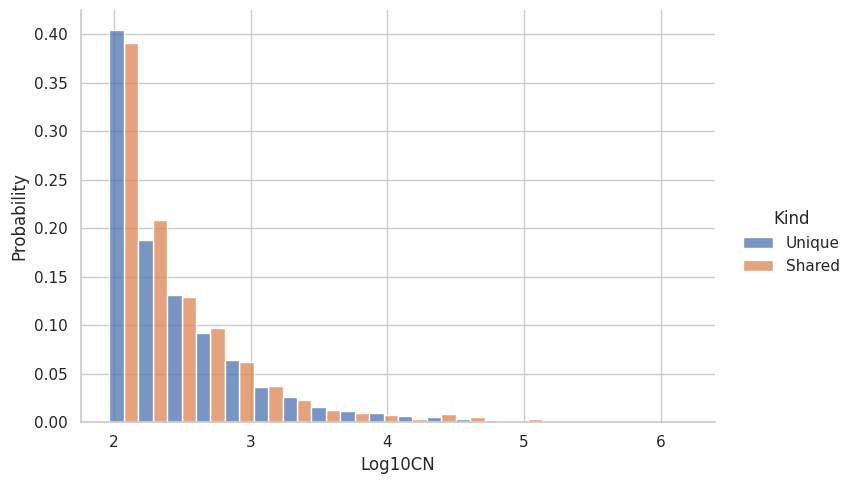

In [91]:
temp_df = df2.copy()
ax = sns.displot(data=temp_df, x="Log10CN", kind="hist", bins = 20,hue = 'Kind',
                 common_norm = False, aspect = 1.5,log_scale = [False,False],stat='probability',multiple = 'dodge' )

Text(0.4, 0.85, 'P-value = 0.52')

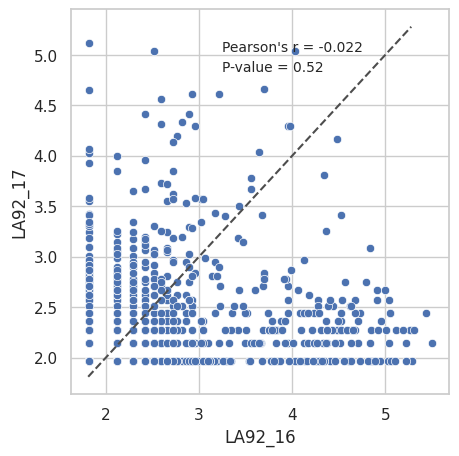

In [92]:
gs = gridspec.GridSpec(5, 17) 
fig1 = plt.figure(figsize=(17,5))


# xtitle = 'Tumor fraction in K mice'
# ytitle = 'sgRNA reads fraction in plasmid library'

ax1=fig1.add_subplot(gs[:5, 0:5])
temp_df = re_shaped_df
ix = test_sample[0]
iy = test_sample[1]
sns.scatterplot(x=ix, y=iy, data=temp_df,ax= ax1)
# ax1.set_xlabel(xtitle)
# ax1.set_ylabel(ytitle)
temp1 = max(ax1.get_xlim()[0],ax1.get_ylim()[0])
temp2 = min(ax1.get_xlim()[1],ax1.get_ylim()[1])
diag_line, = ax1.plot((temp1,temp2),(temp1,temp2), ls="--", c=".3")
temp1 = scipy.stats.pearsonr(temp_df[ix],temp_df[iy])[0]
temp2 = scipy.stats.pearsonr(temp_df[ix],temp_df[iy])[1]
ax1.text(0.40,0.9, "Pearson's r = "+str(round(temp1,3)), size=10, ha="left",verticalalignment='center', transform=ax1.transAxes)
ax1.text(0.40,0.85, f"P-value = {temp2:.2f}", size=10, ha="left",verticalalignment='center', transform=ax1.transAxes)

----

## 8 Output data for bootstrapping analysis

In [95]:
anotated_df.Gene1.unique()

array(['Kat6b', 'Spikein_1', 'Kmt2a', 'Kat7', 'Meaf6', 'Safe_16', 'Kat5',
       'Safe_37', 'NT_1', 'Spikein_3', 'Ing5', 'NT_2', 'Spikein_2'],
      dtype=object)

In [96]:
anotated_df.Gene2.unique()

array(['Psip1', 'Kmt2a', 'Kat7', 'Jade2', 'Meaf6', 'Ing4', 'Safe_16',
       'Pcna', 'Safe_37', 'Kat6a', 'NT_1', 'Epc1', 'NT_2', 'Epc2',
       'Spikein_4'], dtype=object)

In [97]:
Final_data = anotated_df[anotated_df.Array_category!='Spikein']
Final_data = Final_data[~Final_data.Sample_ID.isin(sample_to_throw)]
Final_data['Type'] = 'Experiment'
Final_data.loc[(Final_data.Guide1.str.contains('NT|Safe')&Final_data.Guide2.str.contains('NT|Safe')),'Type'] = 'Inert'

In [98]:
Final_data.groupby('Mouse_genotype', as_index=False)['Sample_ID'].nunique()

,Mouse_genotype,Sample_ID
0,KT,5
1,KTHC,18


In [99]:
Final_data[Final_data.Cell_number>=100].groupby('Mouse_genotype', as_index=False)['Sample_ID'].count()

,Mouse_genotype,Sample_ID
0,KT,168498
1,KTHC,421365


In [100]:
Final_data[Final_data.Cell_number>=300].groupby('Mouse_genotype', as_index=False)['Sample_ID'].count()

,Mouse_genotype,Sample_ID
0,KT,69993
1,KTHC,188423


In [189]:
len(set(ref_df.gene_combination_unordered))

122

In [106]:
69993/122

573.7131147540983

In [107]:
Final_data.to_parquet(final_data_output_address,index =False)

In [108]:
# Final_data = pd.read_parquet(final_data_output_address)

In [126]:
def categorize(gene_combo):
    genes = gene_combo.split('|') if '|' in gene_combo else [gene_combo]
    safe_count = sum(('Safe' in gene or 'NT' in gene) for gene in genes)

    if safe_count == 0:
        return 'Double_KO'
    elif safe_count == 1:
        return 'Single_KO'
    elif safe_count == 2:
        return 'Inert'
    else:
        return 'Invalid'


In [127]:
Final_data['Array_category'] = Final_data['gene_combination_unordered'].apply(categorize)

### 8.2 Check missing guide

In [134]:
query_df = Final_data[Final_data.Cell_number>=300]

In [135]:
KT_guide_pool = set(query_df[query_df.Mouse_genotype=='KT']['gRNA_combination'])
KTHC_guide_pool = set(query_df[query_df.Mouse_genotype=='KTHC']['gRNA_combination'])
BTHC_guide_pool = set(query_df[query_df.Mouse_genotype=='BTHC']['gRNA_combination'])

In [136]:
overall_pool = set(ref_df.gRNA_combination)

In [137]:
dif = KTHC_guide_pool-KT_guide_pool
print(len(dif))

0


In [138]:
ref_df[ref_df.gRNA_combination.isin(dif)]

,Gene1,gRNA1,Guide1,Gene2,gRNA2,Guide2,gRNA_combination,Array_category,gRNA_combination_unordered,gene_combination,gene_combination_unordered


### 8.3 Combine Inert and output

In [141]:
# Example inert list
inert_list = ['Safe_16', 'Safe_37', 'NT_1', 'NT_2']

# Build a regex pattern to match any of the substrings
pattern = '|'.join(map(re.escape, inert_list))

# Replace any matching substring with 'Inert'
Final_data_v2 = Final_data.replace(to_replace=pattern, value='Inert', regex=True)

In [143]:
Final_data_v2[Final_data_v2.Gene1.str.contains('Inert')].head()

,gRNA_combination,Clonal_barcode,gRNA1,gRNA2,Sample_ID,Count,Gene1,Guide1,Gene2,Guide2,Array_category,gRNA_combination_unordered,gene_combination,gene_combination_unordered,Mouse_genotype,Virus_titer,Time_after_tumor_initiation,Total_lung_weight,Sex,Project_barcode,Cell_number_per_read,Correction_for_spikein,Cell_number,Type
18313,AGTACACTATAGTGGCTAGT_AAAAATTTAGCTAAACCAG,AATTTAAATGTCTTAT,AGTACACTATAGTGGCTAGT,AAAAATTTAGCTAAACCAG,LA92_10,1,Inert,Inert,Psip1,Psip1_1,Single_KO,AAAAATTTAGCTAAACCAG_AGTACACTATAGTGGCTAGT,Inert_Psip1,Psip1_Inert,KTHC,330000,16,0.402,F,Match,61.652281,No,61.652281,Experiment
18314,AGTACACTATAGTGGCTAGT_AAAAATTTAGCTAAACCAG,ACCTAAGATCTAAGGA,AGTACACTATAGTGGCTAGT,AAAAATTTAGCTAAACCAG,LA92_10,4,Inert,Inert,Psip1,Psip1_1,Single_KO,AAAAATTTAGCTAAACCAG_AGTACACTATAGTGGCTAGT,Inert_Psip1,Psip1_Inert,KTHC,330000,16,0.402,F,Match,61.652281,No,246.609125,Experiment
18315,AGTACACTATAGTGGCTAGT_AAAAATTTAGCTAAACCAG,ACTTGAGATTTGTCCC,AGTACACTATAGTGGCTAGT,AAAAATTTAGCTAAACCAG,LA92_10,1,Inert,Inert,Psip1,Psip1_1,Single_KO,AAAAATTTAGCTAAACCAG_AGTACACTATAGTGGCTAGT,Inert_Psip1,Psip1_Inert,KTHC,330000,16,0.402,F,Match,61.652281,No,61.652281,Experiment
18316,AGTACACTATAGTGGCTAGT_AAAAATTTAGCTAAACCAG,AGACCAAATGTCCGGT,AGTACACTATAGTGGCTAGT,AAAAATTTAGCTAAACCAG,LA92_10,2,Inert,Inert,Psip1,Psip1_1,Single_KO,AAAAATTTAGCTAAACCAG_AGTACACTATAGTGGCTAGT,Inert_Psip1,Psip1_Inert,KTHC,330000,16,0.402,F,Match,61.652281,No,123.304562,Experiment
18317,AGTACACTATAGTGGCTAGT_AAAAATTTAGCTAAACCAG,AGATTATATGTCTTCA,AGTACACTATAGTGGCTAGT,AAAAATTTAGCTAAACCAG,LA92_10,5,Inert,Inert,Psip1,Psip1_1,Single_KO,AAAAATTTAGCTAAACCAG_AGTACACTATAGTGGCTAGT,Inert_Psip1,Psip1_Inert,KTHC,330000,16,0.402,F,Match,61.652281,No,308.261406,Experiment


In [18]:
# Final_data_v2 = pd.read_parquet(inert_combined_final_data_output_address)

In [19]:
n=2
# Generate the list of gRNA and gene column names dynamically based on n
gRNA_columns = [f'gRNA{i}' for i in range(1, n + 1)]
gene_columns = [f'Gene{i}' for i in range(1, n + 1)]
# Generate combinations at gRNA and gene levels
Final_data_v2['gRNA_combination_unordered'] = Final_data_v2[gRNA_columns].agg(lambda row: '_'.join(sorted(row)), axis=1)
Final_data_v2['gene_combination_unordered'] = Final_data_v2[gene_columns].agg(lambda row: '_'.join(sorted(row)), axis=1)

In [20]:
Final_data_v2.to_parquet(inert_combined_final_data_output_address,index=False)

### 8.4 Exclude any potential template switching

In [21]:
Final_data_v3 = Final_data_v2.loc[
    Final_data_v2.groupby(['Sample_ID', 'gRNA1', 'Clonal_barcode'])['Cell_number'].idxmax()
].reset_index(drop=True)


In [22]:
Final_data_v3[Final_data_v3.Cell_number>=300].groupby('Mouse_genotype', as_index=False)['Sample_ID'].count()

,Mouse_genotype,Sample_ID
0,KT,33396
1,KTHC,73004


In [23]:
73004/122

598.3934426229508

In [25]:
# Final_data[Final_data.Cell_number>=100].groupby('Mouse_genotype', as_index=False)['Sample_ID'].count()

In [26]:
no_template_switching_inert_combined_final_data_output_address

'/labs/mwinslow/Haiqing/UltraSeq_Projects/Kat7_dual_guide_tumor/02_data_cleaning_and_QC/data/Kat7_DualGuide_no_TS_inert_combined_df.parquet'

In [27]:
Final_data_v3.to_parquet(no_template_switching_inert_combined_final_data_output_address,index=False)

In [30]:
Final_data_v3[Final_data_v3.gene_combination_unordered.str.contains('Meaf6')]['gene_combination_unordered'].unique()

array(['Kat6b_Meaf6', 'Kmt2a_Meaf6', 'Kat7_Meaf6', 'Meaf6_Pcna',
       'Epc1_Meaf6', 'Meaf6_Meaf6', 'Kat6a_Meaf6', 'Meaf6_Psip1',
       'Inert_Meaf6', 'Ing4_Meaf6', 'Epc2_Meaf6', 'Jade2_Meaf6',
       'Kat5_Meaf6', 'Ing5_Meaf6'], dtype=object)

In [180]:
# I a df caleld Final_data_v2, its column called Sample_ID, gRNA1,Clonal_barcode,gRNA2,Cell_number
# for each Sample_ID, for each gRNA1+Clonal_barcode combination, I only retain rows that Cell_number is the largest

## 9 Templat switching

### 9.1 Using a gradient of cutoff

In [ ]:
# Define a range of cutoffs
cutoffs = [5, 10, 50, 100, 200, 400]

# Define grouping scenarios clearly
panels = {
    "Barcode_gRNA1": ['Clonal_barcode', 'gRNA1'],
    "Barcode_gRNA2": ['Clonal_barcode', 'gRNA2'],
    "Barcode_only": ['Clonal_barcode']
}

all_results = []

for cutoff in cutoffs:
    # Filter data based on current cutoff
    filtered_df = Final_data[
        (Final_data['Cell_number'] >= cutoff) & (Final_data['Count'] > 2)
    ].copy()

    panel_results = {}

    # Compute fractions for each defined scenario
    for panel_name, grouping_columns in panels.items():
        results = []

        for sample_id, sample_group in filtered_df.groupby('Sample_ID'):
            total_tumors = len(sample_group)
            matching_tumors = 0

            grouping_key = grouping_columns[0] if len(grouping_columns) == 1 else grouping_columns
            for _, group in sample_group.groupby(grouping_key):
                if len(group) > 1:
                    matching_tumors += len(group)

            fraction_key = 'TS_fraction_total' if panel_name == 'Barcode_only' else f'TS_fraction_{panel_name[-5:]}'
            fraction = matching_tumors / total_tumors if total_tumors > 0 else 0

            results.append({
                'Sample_ID': sample_id,
                fraction_key: fraction,
                'Total_tumors': total_tumors  # Add total tumor count
            })

        panel_results[panel_name] = pd.DataFrame(results)

    # Explicit calculation for tumors sharing barcode but neither gRNA1 nor gRNA2
    neither_shared_results = []

    for sample_id, sample_group in filtered_df.groupby('Sample_ID'):
        total_tumors = len(sample_group)
        counted_tumors = 0

        for _, barcode_group in sample_group.groupby('Clonal_barcode'):
            if len(barcode_group) > 1:
                gRNA1_counts = barcode_group['gRNA1'].value_counts()
                gRNA2_counts = barcode_group['gRNA2'].value_counts()

                unique_tumors = barcode_group[
                    (barcode_group['gRNA1'].map(gRNA1_counts) == 1) &
                    (barcode_group['gRNA2'].map(gRNA2_counts) == 1)
                ]

                counted_tumors += len(unique_tumors)

        fraction_neither_shared = counted_tumors / total_tumors if total_tumors > 0 else 0

        neither_shared_results.append({
            'Sample_ID': sample_id,
            'TS_fraction_neither_shared': fraction_neither_shared
        })

    panel_results['Neither_shared'] = pd.DataFrame(neither_shared_results)

    # Merge results from all panels into a single DataFrame
    combined_df = (
        panel_results['Barcode_gRNA1']
        .merge(panel_results['Barcode_gRNA2'], on=['Sample_ID', 'Total_tumors'])
        .merge(panel_results['Barcode_only'], on=['Sample_ID', 'Total_tumors'])
        .merge(panel_results['Neither_shared'], on='Sample_ID')
    )

    # Add cutoff column and store results
    combined_df['Cutoff'] = cutoff
    all_results.append(combined_df)

# Combine all cutoff results
final_combined_results = pd.concat(all_results, ignore_index=True)

# Optional: sort and reorder columns
final_combined_results = final_combined_results[
    ['Sample_ID', 'Cutoff', 'Total_tumors',
     'TS_fraction_gRNA1', 'TS_fraction_gRNA2',
     'TS_fraction_total', 'TS_fraction_neither_shared']
].sort_values(by=['Sample_ID', 'Cutoff'])

# Optional: save
final_combined_results.sort_values(by=['Cutoff', 'TS_fraction_total'], inplace=True)
final_combined_results.to_csv(f"{working_dir}{project_prefix}_template_switch_gradient_cutoffs.csv", index=False)


In [ ]:
# For each scenario, the following steps occur:

# Loop over each Sample_ID:
# The code separates the data by unique Sample_IDs to perform analysis within each group independently.

# Within each Sample_ID:

# It calculates the total number of tumor groups (total_tumors).

# Then it groups data by the selected barcode(s) combination (panel-dependent) and identifies barcode groups containing more than one tumor.

# It counts the total number of tumors (tumors_with_matching_barcode) that share at least one identical barcode combination with another tumor in the same group.

# Calculating Fractions:
# The fraction is calculated as:

<font size="10" color="red"> 
\[
\text{Fraction} = \frac{\text{tumors\_with\_matching\_barcode}}{\text{total\_tumors}}
\]
</font>


### 9.2 Check a specific cutoff

In [160]:
probability_df = final_combined_results[final_combined_results.Cutoff==100]

In [161]:
new_s_df = read_dist_df.merge(probability_df, on='Sample_ID', how='right')
new_s_df.to_csv(read_dist_output_address,index=False)

### 9.4 Plotting

In [167]:
final_combined_results[final_combined_results.Cutoff>300]

,Sample_ID,Cutoff,Total_tumors,TS_fraction_gRNA1,TS_fraction_gRNA2,TS_fraction_total,TS_fraction_neither_shared
125,LA92_15,400,257,0.000000,0.000000,0.000000,0.000000
115,LA92_01,400,4282,0.033629,0.009341,0.160906,0.118169
124,LA92_14,400,1684,0.241093,0.004751,0.268409,0.023753
117,LA92_04,400,4186,0.178930,0.007645,0.275681,0.091495
128,LA92_19,400,1220,0.304918,0.001639,0.332787,0.027049
137,LA92_29,400,5188,0.308019,0.009252,0.404202,0.090401
132,LA92_23,400,5239,0.319527,0.011453,0.409238,0.081313
131,LA92_22,400,2884,0.395978,0.006935,0.433426,0.032940
123,LA92_12,400,5831,0.398559,0.012005,0.475905,0.070314
116,LA92_02,400,13809,0.245130,0.032877,0.492360,0.224346


In [162]:
final_combined_results.head()

,Sample_ID,Cutoff,Total_tumors,TS_fraction_gRNA1,TS_fraction_gRNA2,TS_fraction_total,TS_fraction_neither_shared
10,LA92_15,5,828,0.016908,0.002415,0.050725,0.031401
0,LA92_01,5,11137,0.524288,0.021729,0.625034,0.091587
13,LA92_19,5,10008,0.714329,0.015388,0.752098,0.032374
1,LA92_02,5,30841,0.662268,0.059726,0.802730,0.120327
21,LA92_27,5,16195,0.780488,0.025440,0.812164,0.026551


/tmp/ipykernel_20008/3431968959.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(
/tmp/ipykernel_20008/3431968959.py:41: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


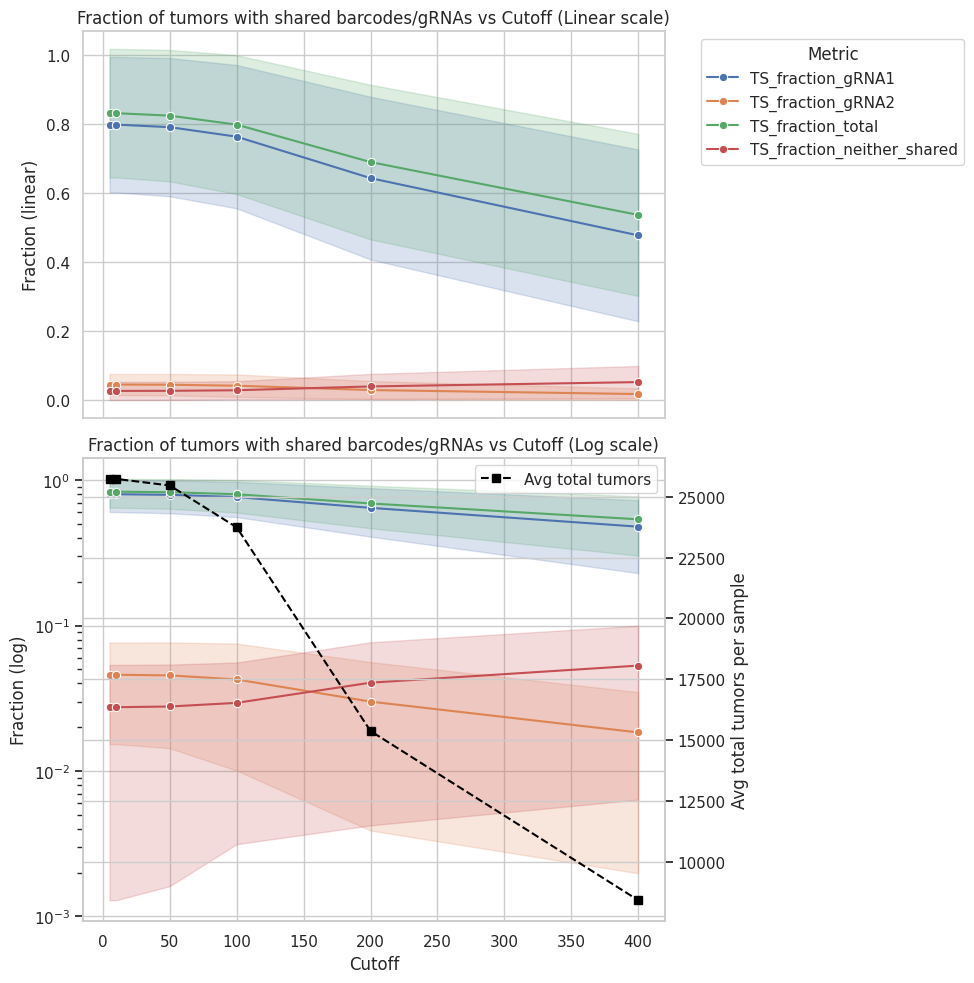

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Melt the fraction data
df_melted = final_combined_results.melt(
    id_vars=['Sample_ID', 'Cutoff', 'Total_tumors'],
    value_vars=[
        'TS_fraction_gRNA1',
        'TS_fraction_gRNA2',
        'TS_fraction_total',
        'TS_fraction_neither_shared'
    ],
    var_name='Metric',
    value_name='Fraction'
)

# Step 2: Compute mean Total_tumors per cutoff for overlay
tumor_means = final_combined_results.groupby('Cutoff')['Total_tumors'].mean()

# Step 3: Set up subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1.2]})

# Top panel — linear scale
sns.lineplot(
    data=df_melted,
    x='Cutoff',
    y='Fraction',
    hue='Metric',
    estimator='mean',
    ci='sd',
    marker='o',
    ax=ax1
)
ax1.set_title("Fraction of tumors with shared barcodes/gRNAs vs Cutoff (Linear scale)")
ax1.set_ylabel("Fraction (linear)")
ax1.set_xlabel("")
ax1.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')

# Bottom panel — log scale
sns.lineplot(
    data=df_melted,
    x='Cutoff',
    y='Fraction',
    hue='Metric',
    estimator='mean',
    ci='sd',
    marker='o',
    ax=ax2,
    legend=False
)
ax2.set_yscale('log')
ax2.set_title("Fraction of tumors with shared barcodes/gRNAs vs Cutoff (Log scale)")
ax2.set_ylabel("Fraction (log)")
ax2.set_xlabel("Cutoff")

# Secondary Y-axis for total tumors
ax2_right = ax2.twinx()
ax2_right.plot(tumor_means.index, tumor_means.values, color='black', linestyle='--', marker='s', label='Avg total tumors')
ax2_right.set_ylabel("Avg total tumors per sample")
ax2_right.legend(loc='upper right')

plt.tight_layout()
plt.show()


/tmp/ipykernel_20008/823122851.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='TS_fraction_total', data=probability_df, palette='Set2', ax=axes[0])
/tmp/ipykernel_20008/823122851.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='TS_fraction_gRNA1', data=probability_df, palette='Set2', ax=axes[1])
/tmp/ipykernel_20008/823122851.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='TS_fraction_gRNA2', data=probability_df, palette='Set2', ax=axes[2])
/tmp/ipykernel_20008/823122851.py:20: FutureWarning: 

Passing `palette` without

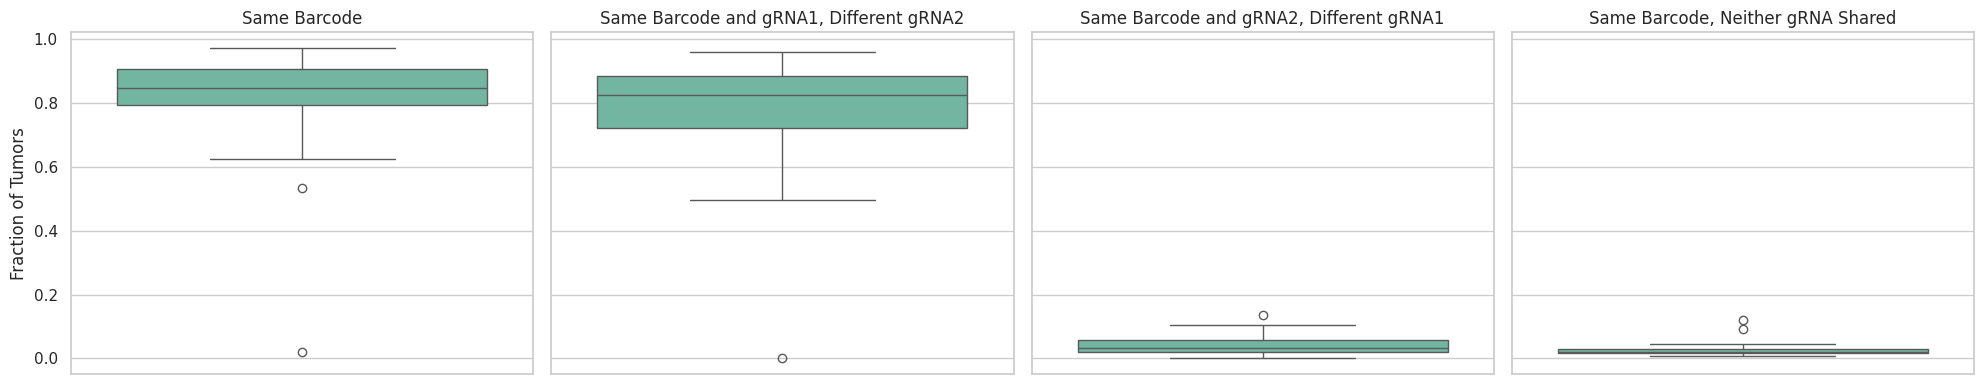

In [164]:
# Create a figure with four subplots (panels) sharing the same y-axis range
fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharey=True)

# Panel 1: Same barcode
sns.boxplot(y='TS_fraction_total', data=probability_df, palette='Set2', ax=axes[0])
axes[0].set_title('Same Barcode')
axes[0].set_ylabel('Fraction of Tumors')

# Panel 2: Same barcode and gRNA1
sns.boxplot(y='TS_fraction_gRNA1', data=probability_df, palette='Set2', ax=axes[1])
axes[1].set_title('Same Barcode and gRNA1, Different gRNA2')
axes[1].set_ylabel('')  # Remove y-axis label to reduce redundancy

# Panel 3: Same barcode and gRNA2
sns.boxplot(y='TS_fraction_gRNA2', data=probability_df, palette='Set2', ax=axes[2])
axes[2].set_title('Same Barcode and gRNA2, Different gRNA1')
axes[2].set_ylabel('')  # Remove y-axis label to reduce redundancy

# Panel 4: Same barcode, neither gRNA shared
sns.boxplot(y='TS_fraction_neither_shared', data=probability_df, palette='Set2', ax=axes[3])
axes[3].set_title('Same Barcode, Neither gRNA Shared')
axes[3].set_ylabel('')  # Remove y-axis label to reduce redundancy

# Adjust layout and aesthetics
plt.tight_layout()
plt.show()


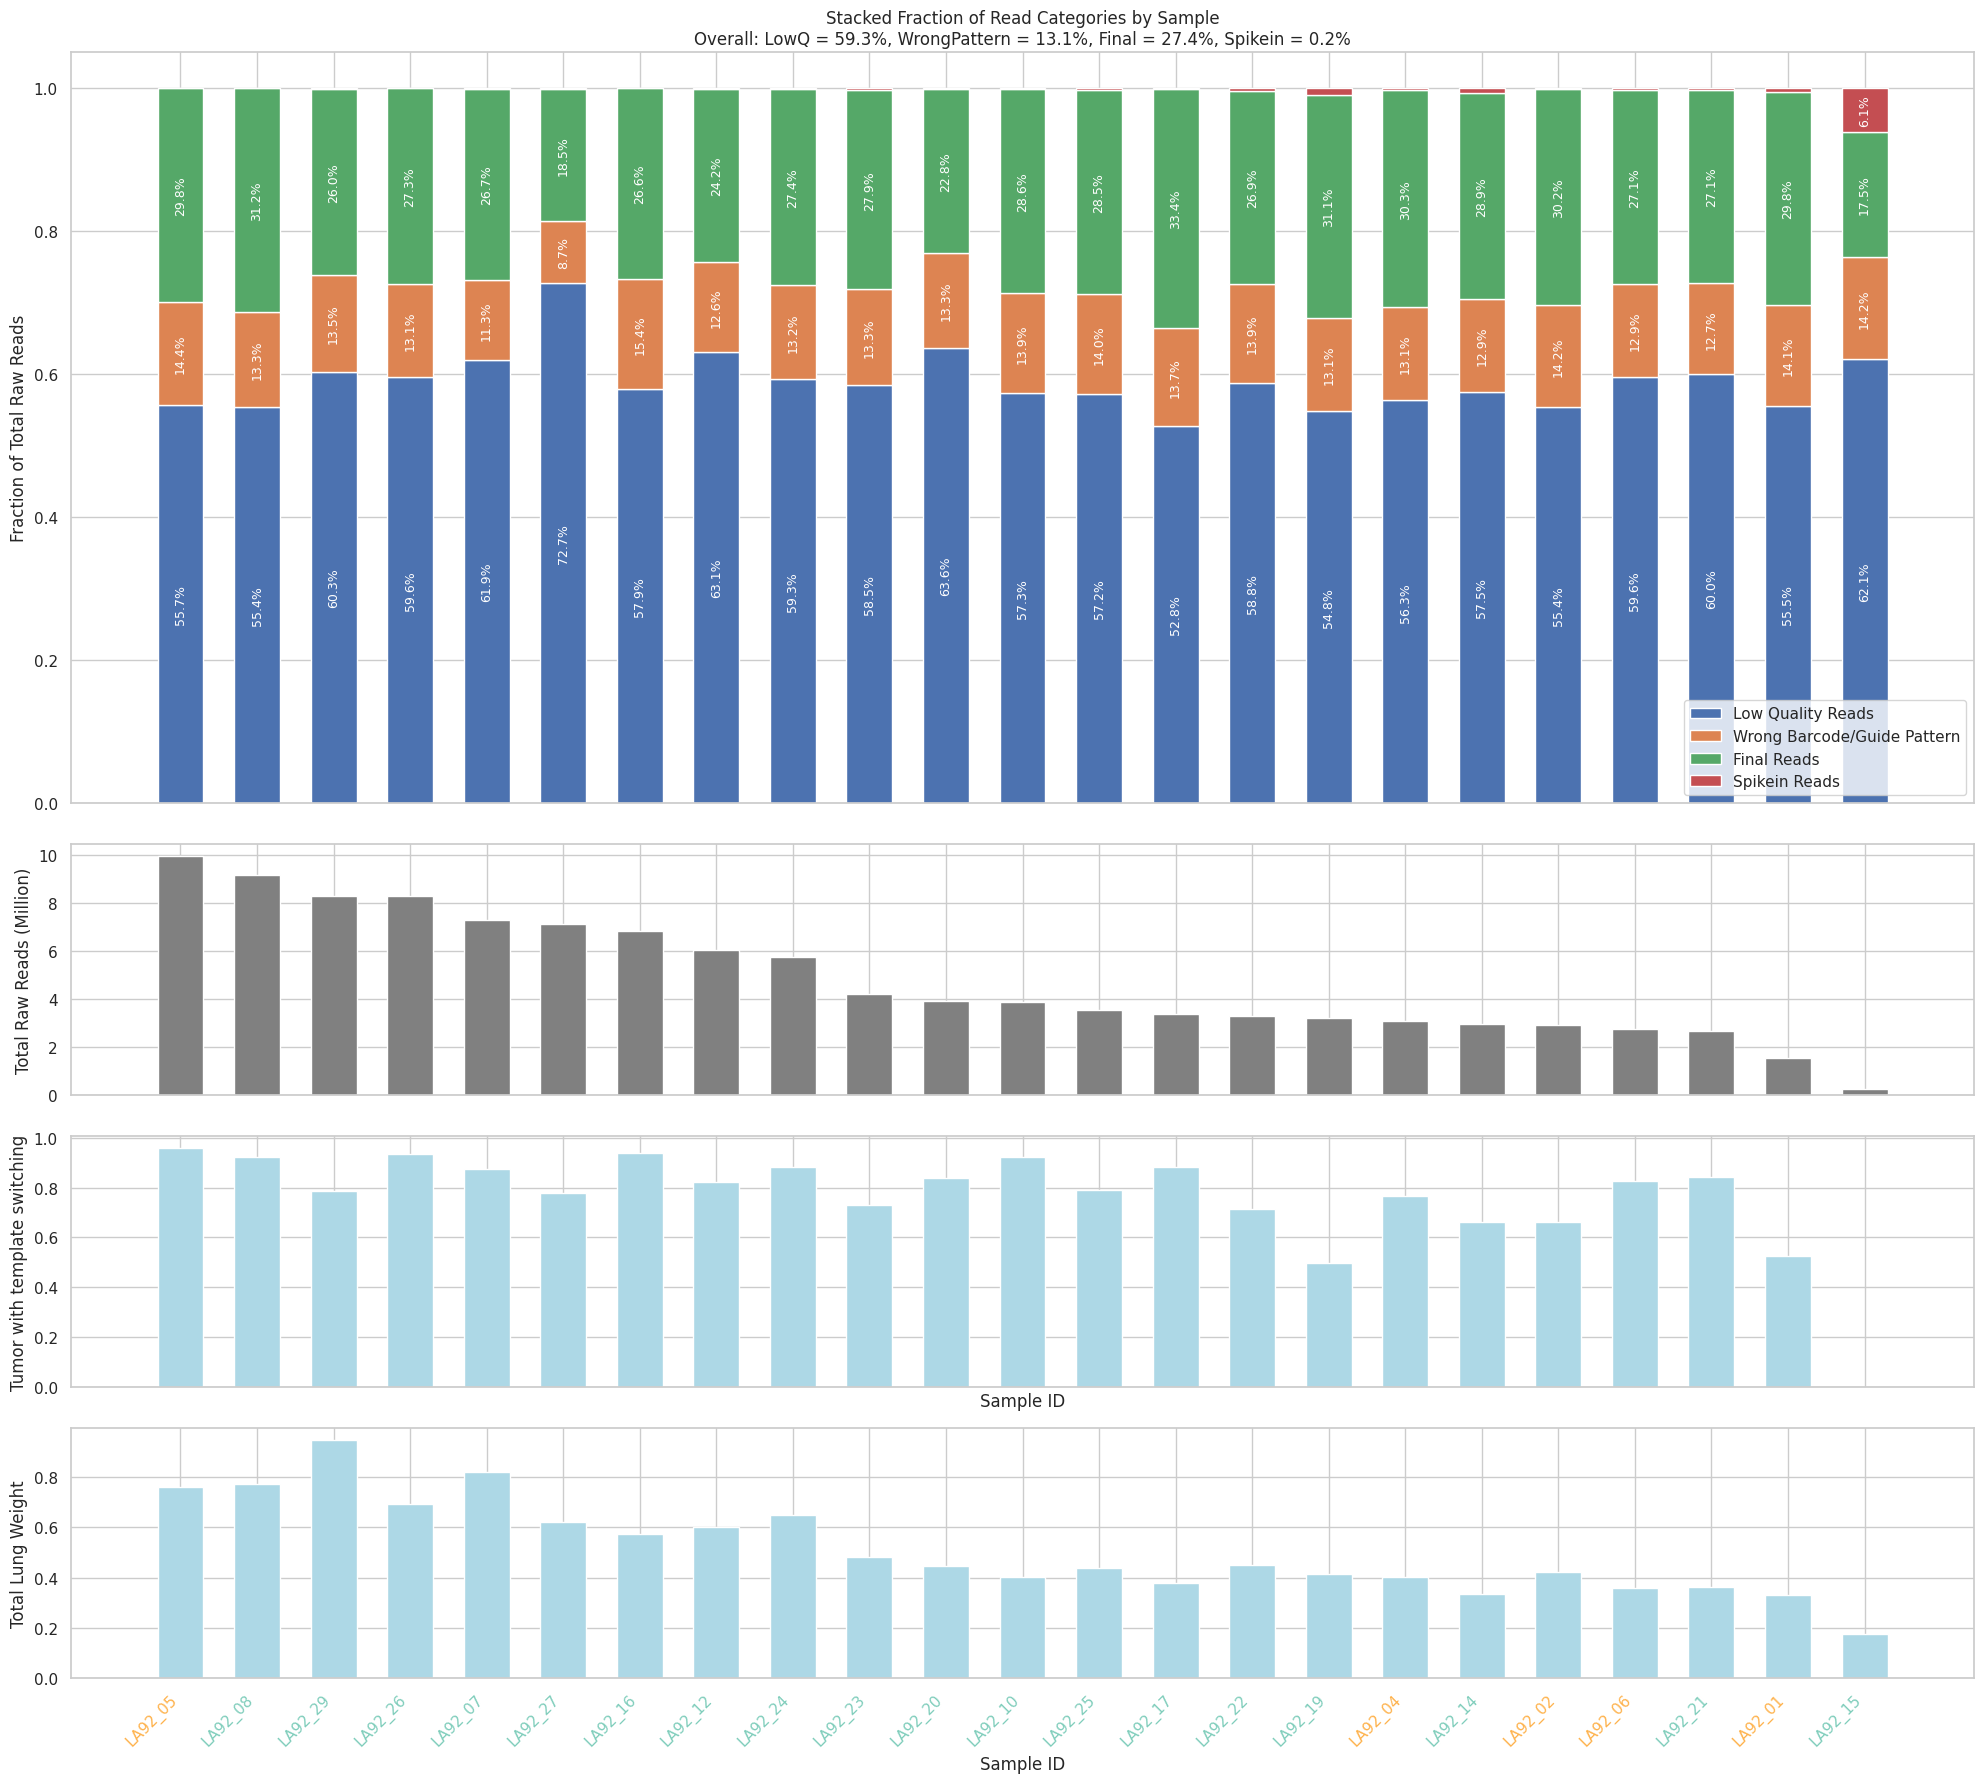

In [188]:
# Sort dataframe by total_raw_reads (descending)
raw_read_input_sorted = new_s_df.sort_values(by='total_raw_reads', ascending=False).reset_index(drop=True)

# Compute overall totals and fractions
overall_total = raw_read_input_sorted['total_raw_reads'].sum()
overall_lowq = raw_read_input_sorted['lowQ_reads'].sum()
overall_wo_pattern = raw_read_input_sorted['reads_wo_pattern'].sum()
overall_final = raw_read_input_sorted['reads_after_filtering'].sum()
overall_spikein = raw_read_input_sorted['reads_spikein'].sum()

overall_frac_lowq = overall_lowq / overall_total
overall_frac_wo_pattern = overall_wo_pattern / overall_total
overall_frac_final = overall_final / overall_total
overall_frac_spikein = overall_spikein / overall_total

# X positions
x = np.arange(len(raw_read_input_sorted))
bar_width = 0.6

# Fraction arrays
f_lowq = raw_read_input_sorted['frac_lowQ_reads'].values
f_wo_pattern = raw_read_input_sorted['frac_wo_pattern'].values
f_final = raw_read_input_sorted['frac_final'].values
f_spikein = raw_read_input_sorted['frac_spikein'].values

# Define colors based on Mouse_genotype
x_label_colors = [genotype_colors.get(gt, 'gray') for gt in raw_read_input_sorted['Mouse_genotype']]

# Create figure with three subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 18), gridspec_kw={'height_ratios': [3, 1, 1,1]}, sharex=True)

# Upper panel: Stacked fraction plot
ax1.bar(x, f_lowq, width=bar_width, label='Low Quality Reads')
ax1.bar(x, f_wo_pattern, width=bar_width, bottom=f_lowq, label='Wrong Barcode/Guide Pattern')
ax1.bar(x, f_final, width=bar_width, bottom=f_lowq + f_wo_pattern, label='Final Reads')
ax1.bar(x, f_spikein, width=bar_width, bottom=f_lowq + f_wo_pattern + f_final, label='Spikein Reads')

# Annotate each segment if its value is significant (>5%)
for i in range(len(x)):
    y_offset = 0
    for val in [f_lowq[i], f_wo_pattern[i], f_final[i], f_spikein[i]]:
        if val > 0.05:
            ax1.text(x[i], y_offset + val / 2, f"{val:.1%}", ha='center', va='center', color='white', fontsize=9, rotation=90)
        y_offset += val

# Axis labels and title for fraction plot
ax1.set_ylabel('Fraction of Total Raw Reads')
ax1.set_title(
    f"Stacked Fraction of Read Categories by Sample\n"
    f"Overall: LowQ = {overall_frac_lowq:.1%}, WrongPattern = {overall_frac_wo_pattern:.1%}, "
    f"Final = {overall_frac_final:.1%}, Spikein = {overall_frac_spikein:.1%}"
)
ax1.legend(loc='lower right')

# Middle panel: Total reads bar plot
ax2.bar(x, raw_read_input_sorted['total_raw_reads'].values / 1e6, width=bar_width, color='gray')
ax2.set_ylabel('Total Raw Reads (Million)')

# Lower panel: Fraction_Matching_ClonalBarcode
ax3.bar(x, raw_read_input_sorted['TS_fraction_gRNA1'].values, width=bar_width, color='lightblue')
ax3.set_ylabel('Tumor with template switching')
ax3.set_xlabel('Sample ID')


# Lower panel: Total lung weight
ax4.bar(x, raw_read_input_sorted['Total_lung_weight'].values, width=bar_width, color='lightblue')
ax4.set_ylabel('Total Lung Weight')
ax4.set_xlabel('Sample ID')

# X-axis sample IDs
ax4.set_xticks(x)
ax4.set_xticklabels(raw_read_input_sorted['Sample_ID'], rotation=45, ha='right', color='black')

# Apply genotype-based colors to x-axis labels
for tick_label, color in zip(ax4.get_xticklabels(), x_label_colors):
    tick_label.set_color(color)

plt.tight_layout()

plt.savefig(fig_output_address1, format='pdf')
plt.show()

----

## 10 Exmaples

In [169]:
xu_df = Final_data[Final_data.Sample_ID=='LA92_05'].sort_values(by='Cell_number',ascending=False)

In [173]:
xu_df[xu_df.Cell_number<100000].sort_values(by='Cell_number',ascending=False)

,gRNA_combination,Clonal_barcode,gRNA1,gRNA2,Sample_ID,Count,Gene1,Guide1,Gene2,Guide2,Array_category,gRNA_combination_unordered,gene_combination,gene_combination_unordered,Mouse_genotype,Virus_titer,Time_after_tumor_initiation,Total_lung_weight,Sex,Project_barcode,Cell_number_per_read,Correction_for_spikein,Cell_number,Type
710839,CTTCACGCCTTGGACCGATA_CCAATAGCAAAAACGACCGG,TTCGAATATGTGTCTC,CTTCACGCCTTGGACCGATA,CCAATAGCAAAAACGACCGG,LA92_05,2260,NT_2,NT_2,Meaf6,Meaf6_4,Single_KO,CCAATAGCAAAAACGACCGG_CTTCACGCCTTGGACCGATA,NT_2_Meaf6,Meaf6_NT_2,KT,330000,16,0.761,M,Match,44.11116,No,99691.221879,Experiment
596033,AAAGGGGTCGTAAACGCAGG_AGGTAGACAAACACATTCGG,GTGTTATATGTCTGTA,AAAGGGGTCGTAAACGCAGG,AGGTAGACAAACACATTCGG,LA92_05,2252,Kat6b,Kat6b_1,Ing4,Ing4_1,Double_KO,AAAGGGGTCGTAAACGCAGG_AGGTAGACAAACACATTCGG,Kat6b_Ing4,Ing4_Kat6b,KT,330000,16,0.761,M,Match,44.11116,No,99338.332598,Experiment
606628,ACGGTAGCGCAGCAAGTGAC_ATTGGTGGCGAGTTTGACCG,AGAGTACATGTCCAGG,ACGGTAGCGCAGCAAGTGAC,ATTGGTGGCGAGTTTGACCG,LA92_05,2244,Kmt2a,Kmt2a_1,Kat6a,Kat6a_1,Double_KO,ACGGTAGCGCAGCAAGTGAC_ATTGGTGGCGAGTTTGACCG,Kmt2a_Kat6a,Kat6a_Kmt2a,KT,330000,16,0.761,M,Match,44.11116,No,98985.443317,Experiment
656794,ATGTAGGAGCTATAACATC_ATACGTGCAAATTCACCCGA,GTATCAAATTTGTGGA,ATGTAGGAGCTATAACATC,ATACGTGCAAATTCACCCGA,LA92_05,2219,Safe_37,Safe_37,Pcna,Pcna_1,Single_KO,ATACGTGCAAATTCACCCGA_ATGTAGGAGCTATAACATC,Safe_37_Pcna,Pcna_Safe_37,KT,330000,16,0.761,M,Match,44.11116,No,97882.664314,Experiment
671407,CCAAGACCCCTCATACCAAG_ACGGTAGCGCAGCAAGTGAC,GGAGCATATGTGGAGC,CCAAGACCCCTCATACCAAG,ACGGTAGCGCAGCAAGTGAC,LA92_05,2211,Kat5,Kat5_2,Kmt2a,Kmt2a_3,Double_KO,ACGGTAGCGCAGCAAGTGAC_CCAAGACCCCTCATACCAAG,Kat5_Kmt2a,Kat5_Kmt2a,KT,330000,16,0.761,M,Match,44.11116,No,97529.775033,Experiment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599348,AAAGGGGTCGTAAACGCAGG_CCTATCCTGAGGAATATGCG,TAGGAACATTTGAAGG,AAAGGGGTCGTAAACGCAGG,CCTATCCTGAGGAATATGCG,LA92_05,1,Kat6b,Kat6b_1,Kat7,Kat7_4,Double_KO,AAAGGGGTCGTAAACGCAGG_CCTATCCTGAGGAATATGCG,Kat6b_Kat7,Kat6b_Kat7,KT,330000,16,0.761,M,Match,44.11116,No,44.111160,Experiment
718069,TATCCTCTTCTGACGTCCGC_AGTACACTATAGTGGCTAGT,TGACCAGATATTATTG,TATCCTCTTCTGACGTCCGC,AGTACACTATAGTGGCTAGT,LA92_05,1,Ing5,Ing5_2,Safe_16,Safe_16,Single_KO,AGTACACTATAGTGGCTAGT_TATCCTCTTCTGACGTCCGC,Ing5_Safe_16,Ing5_Safe_16,KT,330000,16,0.761,M,Match,44.11116,No,44.111160,Experiment
599349,AAAGGGGTCGTAAACGCAGG_CCTATCCTGAGGAATATGCG,TAGGTAGATGTTACTA,AAAGGGGTCGTAAACGCAGG,CCTATCCTGAGGAATATGCG,LA92_05,1,Kat6b,Kat6b_1,Kat7,Kat7_4,Double_KO,AAAGGGGTCGTAAACGCAGG_CCTATCCTGAGGAATATGCG,Kat6b_Kat7,Kat6b_Kat7,KT,330000,16,0.761,M,Match,44.11116,No,44.111160,Experiment
618164,AGAAAGGGCGGCGATCAAGG_AGCTGGCCGAGCTGGTTAAG,TCTGTATATTTCCAGA,AGAAAGGGCGGCGATCAAGG,AGCTGGCCGAGCTGGTTAAG,LA92_05,1,Kmt2a,Kmt2a_2,Meaf6,Meaf6_3,Double_KO,AGAAAGGGCGGCGATCAAGG_AGCTGGCCGAGCTGGTTAAG,Kmt2a_Meaf6,Kmt2a_Meaf6,KT,330000,16,0.761,M,Match,44.11116,No,44.111160,Experiment


In [170]:
xu_df.sort_values(by='Cell_number',ascending=False)

,gRNA_combination,Clonal_barcode,gRNA1,gRNA2,Sample_ID,Count,Gene1,Guide1,Gene2,Guide2,Array_category,gRNA_combination_unordered,gene_combination,gene_combination_unordered,Mouse_genotype,Virus_titer,Time_after_tumor_initiation,Total_lung_weight,Sex,Project_barcode,Cell_number_per_read,Correction_for_spikein,Cell_number,Type
686758,CCAATAGCAAAAACGACCGG_CTTCCACACGAGAAAGACA,CGTCGATATATAAGTT,CCAATAGCAAAAACGACCGG,CTTCCACACGAGAAAGACA,LA92_05,27198,Meaf6,Meaf6_2,Kat6a,Kat6a_2,Double_KO,CCAATAGCAAAAACGACCGG_CTTCCACACGAGAAAGACA,Meaf6_Kat6a,Kat6a_Meaf6,KT,330000,16,0.761,M,Match,44.11116,No,1.199735e+06,Experiment
644419,AGTACACTATAGTGGCTAGT_TGAGATCGATGCGTACTGGT,GGAGGAGATGTAAGGA,AGTACACTATAGTGGCTAGT,TGAGATCGATGCGTACTGGT,LA92_05,14098,Safe_16,Safe_16,Jade2,Jade2_2,Single_KO,AGTACACTATAGTGGCTAGT_TGAGATCGATGCGTACTGGT,Safe_16_Jade2,Jade2_Safe_16,KT,330000,16,0.761,M,Match,44.11116,No,6.218791e+05,Experiment
683436,CCAATAGCAAAAACGACCGG_AGTACACTATAGTGGCTAGT,CATTTATATTTGTTAG,CCAATAGCAAAAACGACCGG,AGTACACTATAGTGGCTAGT,LA92_05,10660,Meaf6,Meaf6_2,Safe_16,Safe_16,Single_KO,AGTACACTATAGTGGCTAGT_CCAATAGCAAAAACGACCGG,Meaf6_Safe_16,Meaf6_Safe_16,KT,330000,16,0.761,M,Match,44.11116,No,4.702250e+05,Experiment
692090,CCTATCCTGAGGAATATGCG_ATTGGTGGCGAGTTTGACCG,CCTGCAGATTTCCGCG,CCTATCCTGAGGAATATGCG,ATTGGTGGCGAGTTTGACCG,LA92_05,9133,Kat7,Kat7_2,Kat6a,Kat6a_1,Double_KO,ATTGGTGGCGAGTTTGACCG_CCTATCCTGAGGAATATGCG,Kat7_Kat6a,Kat6a_Kat7,KT,330000,16,0.761,M,Match,44.11116,No,4.028672e+05,Experiment
710489,CTTCACGCCTTGGACCGATA_CCAATAGCAAAAACGACCGG,CGCACAAATTTCTAAA,CTTCACGCCTTGGACCGATA,CCAATAGCAAAAACGACCGG,LA92_05,7346,NT_2,NT_2,Meaf6,Meaf6_4,Single_KO,CCAATAGCAAAAACGACCGG_CTTCACGCCTTGGACCGATA,NT_2_Meaf6,Meaf6_NT_2,KT,330000,16,0.761,M,Match,44.11116,No,3.240406e+05,Experiment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599348,AAAGGGGTCGTAAACGCAGG_CCTATCCTGAGGAATATGCG,TAGGAACATTTGAAGG,AAAGGGGTCGTAAACGCAGG,CCTATCCTGAGGAATATGCG,LA92_05,1,Kat6b,Kat6b_1,Kat7,Kat7_4,Double_KO,AAAGGGGTCGTAAACGCAGG_CCTATCCTGAGGAATATGCG,Kat6b_Kat7,Kat6b_Kat7,KT,330000,16,0.761,M,Match,44.11116,No,4.411116e+01,Experiment
718069,TATCCTCTTCTGACGTCCGC_AGTACACTATAGTGGCTAGT,TGACCAGATATTATTG,TATCCTCTTCTGACGTCCGC,AGTACACTATAGTGGCTAGT,LA92_05,1,Ing5,Ing5_2,Safe_16,Safe_16,Single_KO,AGTACACTATAGTGGCTAGT_TATCCTCTTCTGACGTCCGC,Ing5_Safe_16,Ing5_Safe_16,KT,330000,16,0.761,M,Match,44.11116,No,4.411116e+01,Experiment
599349,AAAGGGGTCGTAAACGCAGG_CCTATCCTGAGGAATATGCG,TAGGTAGATGTTACTA,AAAGGGGTCGTAAACGCAGG,CCTATCCTGAGGAATATGCG,LA92_05,1,Kat6b,Kat6b_1,Kat7,Kat7_4,Double_KO,AAAGGGGTCGTAAACGCAGG_CCTATCCTGAGGAATATGCG,Kat6b_Kat7,Kat6b_Kat7,KT,330000,16,0.761,M,Match,44.11116,No,4.411116e+01,Experiment
618164,AGAAAGGGCGGCGATCAAGG_AGCTGGCCGAGCTGGTTAAG,TCTGTATATTTCCAGA,AGAAAGGGCGGCGATCAAGG,AGCTGGCCGAGCTGGTTAAG,LA92_05,1,Kmt2a,Kmt2a_2,Meaf6,Meaf6_3,Double_KO,AGAAAGGGCGGCGATCAAGG_AGCTGGCCGAGCTGGTTAAG,Kmt2a_Meaf6,Kmt2a_Meaf6,KT,330000,16,0.761,M,Match,44.11116,No,4.411116e+01,Experiment


In [ ]:
30000

In [176]:
s1 = xu_df[xu_df.Clonal_barcode=='TTCGAATATGTGTCTC']
s1.sort_values(by='Cell_number',ascending=False)

,gRNA_combination,Clonal_barcode,gRNA1,gRNA2,Sample_ID,Count,Gene1,Guide1,Gene2,Guide2,Array_category,gRNA_combination_unordered,gene_combination,gene_combination_unordered,Mouse_genotype,Virus_titer,Time_after_tumor_initiation,Total_lung_weight,Sex,Project_barcode,Cell_number_per_read,Correction_for_spikein,Cell_number,Type
710839,CTTCACGCCTTGGACCGATA_CCAATAGCAAAAACGACCGG,TTCGAATATGTGTCTC,CTTCACGCCTTGGACCGATA,CCAATAGCAAAAACGACCGG,LA92_05,2260,NT_2,NT_2,Meaf6,Meaf6_4,Single_KO,CCAATAGCAAAAACGACCGG_CTTCACGCCTTGGACCGATA,NT_2_Meaf6,Meaf6_NT_2,KT,330000,16,0.761,M,Match,44.11116,No,99691.221879,Experiment
709078,CTTCACGCCTTGGACCGATA_ATACGTGCAAATTCACCCGA,TTCGAATATGTGTCTC,CTTCACGCCTTGGACCGATA,ATACGTGCAAATTCACCCGA,LA92_05,78,NT_2,NT_2,Pcna,Pcna_1,Single_KO,ATACGTGCAAATTCACCCGA_CTTCACGCCTTGGACCGATA,NT_2_Pcna,NT_2_Pcna,KT,330000,16,0.761,M,Match,44.11116,No,3440.670490,Experiment
706163,CTTCACGCCTTGGACCGATA_AGAAAGGGCGGCGATCAAGG,TTCGAATATGTGTCTC,CTTCACGCCTTGGACCGATA,AGAAAGGGCGGCGATCAAGG,LA92_05,51,NT_2,NT_2,Kmt2a,Kmt2a_4,Single_KO,AGAAAGGGCGGCGATCAAGG_CTTCACGCCTTGGACCGATA,NT_2_Kmt2a,Kmt2a_NT_2,KT,330000,16,0.761,M,Match,44.11116,No,2249.669166,Experiment
707094,CTTCACGCCTTGGACCGATA_AGCTGGCCGAGCTGGTTAAG,TTCGAATATGTGTCTC,CTTCACGCCTTGGACCGATA,AGCTGGCCGAGCTGGTTAAG,LA92_05,46,NT_2,NT_2,Meaf6,Meaf6_3,Single_KO,AGCTGGCCGAGCTGGTTAAG_CTTCACGCCTTGGACCGATA,NT_2_Meaf6,Meaf6_NT_2,KT,330000,16,0.761,M,Match,44.11116,No,2029.113366,Experiment
712646,CTTCACGCCTTGGACCGATA_CTTCACGCCTTGGACCGATA,TTCGAATATGTGTCTC,CTTCACGCCTTGGACCGATA,CTTCACGCCTTGGACCGATA,LA92_05,41,NT_2,NT_2,NT_2,NT_2,Single_KO,CTTCACGCCTTGGACCGATA_CTTCACGCCTTGGACCGATA,NT_2_NT_2,NT_2_NT_2,KT,330000,16,0.761,M,Match,44.11116,No,1808.557565,Inert
708276,CTTCACGCCTTGGACCGATA_AGTACACTATAGTGGCTAGT,TTCGAATATGTGTCTC,CTTCACGCCTTGGACCGATA,AGTACACTATAGTGGCTAGT,LA92_05,39,NT_2,NT_2,Safe_16,Safe_16,Single_KO,AGTACACTATAGTGGCTAGT_CTTCACGCCTTGGACCGATA,NT_2_Safe_16,NT_2_Safe_16,KT,330000,16,0.761,M,Match,44.11116,No,1720.335245,Inert
713699,CTTCACGCCTTGGACCGATA_GCGCTACTCATATATTCAG,TTCGAATATGTGTCTC,CTTCACGCCTTGGACCGATA,GCGCTACTCATATATTCAG,LA92_05,37,NT_2,NT_2,Ing4,Ing4_2,Single_KO,CTTCACGCCTTGGACCGATA_GCGCTACTCATATATTCAG,NT_2_Ing4,Ing4_NT_2,KT,330000,16,0.761,M,Match,44.11116,No,1632.112925,Experiment
712007,CTTCACGCCTTGGACCGATA_CTATGAGTCCATATACCCTG,TTCGAATATGTGTCTC,CTTCACGCCTTGGACCGATA,CTATGAGTCCATATACCCTG,LA92_05,35,NT_2,NT_2,Epc1,Epc1_1,Single_KO,CTATGAGTCCATATACCCTG_CTTCACGCCTTGGACCGATA,NT_2_Epc1,Epc1_NT_2,KT,330000,16,0.761,M,Match,44.11116,No,1543.890604,Experiment
710077,CTTCACGCCTTGGACCGATA_ATTGGTGGCGAGTTTGACCG,TTCGAATATGTGTCTC,CTTCACGCCTTGGACCGATA,ATTGGTGGCGAGTTTGACCG,LA92_05,31,NT_2,NT_2,Kat6a,Kat6a_1,Single_KO,ATTGGTGGCGAGTTTGACCG_CTTCACGCCTTGGACCGATA,NT_2_Kat6a,Kat6a_NT_2,KT,330000,16,0.761,M,Match,44.11116,No,1367.445964,Experiment
713239,CTTCACGCCTTGGACCGATA_CTTCCACACGAGAAAGACA,TTCGAATATGTGTCTC,CTTCACGCCTTGGACCGATA,CTTCCACACGAGAAAGACA,LA92_05,30,NT_2,NT_2,Kat6a,Kat6a_2,Single_KO,CTTCACGCCTTGGACCGATA_CTTCCACACGAGAAAGACA,NT_2_Kat6a,Kat6a_NT_2,KT,330000,16,0.761,M,Match,44.11116,No,1323.334804,Experiment


In [187]:
s1 = Final_data_v3[Final_data_v3.Clonal_barcode=='CGTCGATATATAAGTT']
s1.sort_values(by='Cell_number',ascending=False)

,gRNA_combination,Clonal_barcode,gRNA1,gRNA2,Sample_ID,Count,Gene1,Guide1,Gene2,Guide2,Array_category,gRNA_combination_unordered,gene_combination,gene_combination_unordered,Mouse_genotype,Virus_titer,Time_after_tumor_initiation,Total_lung_weight,Sex,Project_barcode,Cell_number_per_read,Correction_for_spikein,Cell_number,Type
51523,CCAATAGCAAAAACGACCGG_CTTCCACACGAGAAAGACA,CGTCGATATATAAGTT,CCAATAGCAAAAACGACCGG,CTTCCACACGAGAAAGACA,LA92_05,27198,Meaf6,Meaf6_2,Kat6a,Kat6a_2,Double_KO,CCAATAGCAAAAACGACCGG_CTTCCACACGAGAAAGACA,Meaf6_Kat6a,Kat6a_Meaf6,KT,330000,16,0.7610,M,Match,44.111160,No,1.199735e+06,Experiment
165920,AGAAAGGGCGGCGATCAAGG_AGTACACTATAGTGGCTAGT,CGTCGATATATAAGTT,AGAAAGGGCGGCGATCAAGG,AGTACACTATAGTGGCTAGT,LA92_24,364,Kmt2a,Kmt2a_2,Inert,Inert,Single_KO,AGAAAGGGCGGCGATCAAGG_AGTACACTATAGTGGCTAGT,Kmt2a_Inert,Kmt2a_Inert,KTHC,330000,16,0.6500,M,Match,36.249396,No,1.319478e+04,Experiment
50444,CCAAGACCCCTCATACCAAG_ATACGTGCAAATTCACCCGA,CGTCGATATATAAGTT,CCAAGACCCCTCATACCAAG,ATACGTGCAAATTCACCCGA,LA92_05,3,Kat5,Kat5_2,Pcna,Pcna_1,Double_KO,ATACGTGCAAATTCACCCGA_CCAAGACCCCTCATACCAAG,Kat5_Pcna,Kat5_Pcna,KT,330000,16,0.7610,M,Match,44.111160,No,1.323335e+02,Experiment
77080,CCAATAGCAAAAACGACCGG_TATCATTTGGGAGACTATGG,CGTCGATATATAAGTT,CCAATAGCAAAAACGACCGG,TATCATTTGGGAGACTATGG,LA92_08,2,Meaf6,Meaf6_2,Epc2,Epc2_2,Double_KO,CCAATAGCAAAAACGACCGG_TATCATTTGGGAGACTATGG,Meaf6_Epc2,Epc2_Meaf6,KTHC,330000,16,0.7730,M,Match,45.024764,No,9.004953e+01,Experiment
207055,TCCCGAACTCTATTACTGAG_AGTACACTATAGTGGCTAGT,CGTCGATATATAAGTT,TCCCGAACTCTATTACTGAG,AGTACACTATAGTGGCTAGT,LA92_29,2,Kat6b,Kat6b_2,Inert,Inert,Single_KO,AGTACACTATAGTGGCTAGT_TCCCGAACTCTATTACTGAG,Kat6b_Inert,Kat6b_Inert,KTHC,330000,16,0.9470,M,Match,33.905967,No,6.781193e+01,Experiment
114202,CCAATAGCAAAAACGACCGG_CTTCCACACGAGAAAGACA,CGTCGATATATAAGTT,CCAATAGCAAAAACGACCGG,CTTCCACACGAGAAAGACA,LA92_16,1,Meaf6,Meaf6_2,Kat6a,Kat6a_2,Double_KO,CCAATAGCAAAAACGACCGG_CTTCCACACGAGAAAGACA,Meaf6_Kat6a,Kat6a_Meaf6,KTHC,330000,16,0.5750,F,Match,65.132436,No,6.513244e+01,Experiment
64410,AGAAAGGGCGGCGATCAAGG_ACGGTAGCGCAGCAAGTGAC,CGTCGATATATAAGTT,AGAAAGGGCGGCGATCAAGG,ACGGTAGCGCAGCAAGTGAC,LA92_07,1,Kmt2a,Kmt2a_2,Kmt2a,Kmt2a_3,Double_KO,ACGGTAGCGCAGCAAGTGAC_AGAAAGGGCGGCGATCAAGG,Kmt2a_Kmt2a,Kmt2a_Kmt2a,KTHC,330000,16,0.8220,M,Match,43.642712,No,4.364271e+01,Experiment
60605,CCAATAGCAAAAACGACCGG_CTTCCACACGAGAAAGACA,CGTCGATATATAAGTT,CCAATAGCAAAAACGACCGG,CTTCCACACGAGAAAGACA,LA92_06,1,Meaf6,Meaf6_2,Kat6a,Kat6a_2,Double_KO,CCAATAGCAAAAACGACCGG_CTTCCACACGAGAAAGACA,Meaf6_Kat6a,Kat6a_Meaf6,KT,330000,16,0.3606,M,Match,30.138638,No,3.013864e+01,Experiment


In [178]:
s1 = Final_data[Final_data.Clonal_barcode=='CGTCGATATATAAGTT']
s1.sort_values(by='Cell_number',ascending=False)

,gRNA_combination,Clonal_barcode,gRNA1,gRNA2,Sample_ID,Count,Gene1,Guide1,Gene2,Guide2,Array_category,gRNA_combination_unordered,gene_combination,gene_combination_unordered,Mouse_genotype,Virus_titer,Time_after_tumor_initiation,Total_lung_weight,Sex,Project_barcode,Cell_number_per_read,Correction_for_spikein,Cell_number,Type
686758,CCAATAGCAAAAACGACCGG_CTTCCACACGAGAAAGACA,CGTCGATATATAAGTT,CCAATAGCAAAAACGACCGG,CTTCCACACGAGAAAGACA,LA92_05,27198,Meaf6,Meaf6_2,Kat6a,Kat6a_2,Double_KO,CCAATAGCAAAAACGACCGG_CTTCCACACGAGAAAGACA,Meaf6_Kat6a,Kat6a_Meaf6,KT,330000,16,0.7610,M,Match,44.111160,No,1.199735e+06,Experiment
683914,CCAATAGCAAAAACGACCGG_ATACGTGCAAATTCACCCGA,CGTCGATATATAAGTT,CCAATAGCAAAAACGACCGG,ATACGTGCAAATTCACCCGA,LA92_05,768,Meaf6,Meaf6_2,Pcna,Pcna_1,Double_KO,ATACGTGCAAATTCACCCGA_CCAATAGCAAAAACGACCGG,Meaf6_Pcna,Meaf6_Pcna,KT,330000,16,0.7610,M,Match,44.111160,No,3.387737e+04,Experiment
685136,CCAATAGCAAAAACGACCGG_CCAATAGCAAAAACGACCGG,CGTCGATATATAAGTT,CCAATAGCAAAAACGACCGG,CCAATAGCAAAAACGACCGG,LA92_05,422,Meaf6,Meaf6_2,Meaf6,Meaf6_4,Double_KO,CCAATAGCAAAAACGACCGG_CCAATAGCAAAAACGACCGG,Meaf6_Meaf6,Meaf6_Meaf6,KT,330000,16,0.7610,M,Match,44.111160,No,1.861491e+04,Experiment
684637,CCAATAGCAAAAACGACCGG_ATTGGTGGCGAGTTTGACCG,CGTCGATATATAAGTT,CCAATAGCAAAAACGACCGG,ATTGGTGGCGAGTTTGACCG,LA92_05,403,Meaf6,Meaf6_2,Kat6a,Kat6a_1,Double_KO,ATTGGTGGCGAGTTTGACCG_CCAATAGCAAAAACGACCGG,Meaf6_Kat6a,Kat6a_Meaf6,KT,330000,16,0.7610,M,Match,44.111160,No,1.777680e+04,Experiment
683075,CCAATAGCAAAAACGACCGG_AGGTAGACAAACACATTCGG,CGTCGATATATAAGTT,CCAATAGCAAAAACGACCGG,AGGTAGACAAACACATTCGG,LA92_05,399,Meaf6,Meaf6_2,Ing4,Ing4_1,Double_KO,AGGTAGACAAACACATTCGG_CCAATAGCAAAAACGACCGG,Meaf6_Ing4,Ing4_Meaf6,KT,330000,16,0.7610,M,Match,44.111160,No,1.760035e+04,Experiment
686348,CCAATAGCAAAAACGACCGG_CTTCACGCCTTGGACCGATA,CGTCGATATATAAGTT,CCAATAGCAAAAACGACCGG,CTTCACGCCTTGGACCGATA,LA92_05,395,Meaf6,Meaf6_2,NT_2,NT_2,Single_KO,CCAATAGCAAAAACGACCGG_CTTCACGCCTTGGACCGATA,Meaf6_NT_2,Meaf6_NT_2,KT,330000,16,0.7610,M,Match,44.111160,No,1.742391e+04,Experiment
682080,CCAATAGCAAAAACGACCGG_AGAAAGGGCGGCGATCAAGG,CGTCGATATATAAGTT,CCAATAGCAAAAACGACCGG,AGAAAGGGCGGCGATCAAGG,LA92_05,378,Meaf6,Meaf6_2,Kmt2a,Kmt2a_4,Double_KO,AGAAAGGGCGGCGATCAAGG_CCAATAGCAAAAACGACCGG,Meaf6_Kmt2a,Kmt2a_Meaf6,KT,330000,16,0.7610,M,Match,44.111160,No,1.667402e+04,Experiment
683457,CCAATAGCAAAAACGACCGG_AGTACACTATAGTGGCTAGT,CGTCGATATATAAGTT,CCAATAGCAAAAACGACCGG,AGTACACTATAGTGGCTAGT,LA92_05,377,Meaf6,Meaf6_2,Safe_16,Safe_16,Single_KO,AGTACACTATAGTGGCTAGT_CCAATAGCAAAAACGACCGG,Meaf6_Safe_16,Meaf6_Safe_16,KT,330000,16,0.7610,M,Match,44.111160,No,1.662991e+04,Experiment
682707,CCAATAGCAAAAACGACCGG_AGCTGGCCGAGCTGGTTAAG,CGTCGATATATAAGTT,CCAATAGCAAAAACGACCGG,AGCTGGCCGAGCTGGTTAAG,LA92_05,303,Meaf6,Meaf6_2,Meaf6,Meaf6_3,Double_KO,AGCTGGCCGAGCTGGTTAAG_CCAATAGCAAAAACGACCGG,Meaf6_Meaf6,Meaf6_Meaf6,KT,330000,16,0.7610,M,Match,44.111160,No,1.336568e+04,Experiment
922628,AGAAAGGGCGGCGATCAAGG_AGTACACTATAGTGGCTAGT,CGTCGATATATAAGTT,AGAAAGGGCGGCGATCAAGG,AGTACACTATAGTGGCTAGT,LA92_24,364,Kmt2a,Kmt2a_2,Safe_16,Safe_16,Single_KO,AGAAAGGGCGGCGATCAAGG_AGTACACTATAGTGGCTAGT,Kmt2a_Safe_16,Kmt2a_Safe_16,KTHC,330000,16,0.6500,M,Match,36.249396,No,1.319478e+04,Experiment


In [104]:
s2 = s1[s1.gRNA1=='GGCTAAATTTATAATTCCT']
s2

,Clonal_barcode,Sample_ID,gRNA1,gRNA2,gRNA_combination,Count,Gene1,Guide1,Gene2,Guide2,Array_category,gRNA_combination_unordered,gene_combination,gene_combination_unordered,Mouse_genotype,Virus_titer,Time_after_tumor_initiation,Total_lung_weight,Sex,Project_barcode,Cell_number_per_read,Correction_for_spikein,Cell_number,Type
12922189,CAATTAGAAATTGAGA,Dual_ND28,GGCTAAATTTATAATTCCT,AGGGCACTCACCCATGAGCT,GGCTAAATTTATAATTCCT_AGGGCACTCACCCATGAGCT,1118514,Safe33,Safe33_1,Stk11,Stk11_3,Met,AGGGCACTCACCCATGAGCT_GGCTAAATTTATAATTCCT,Safe33_Stk11,Safe33_Stk11,KTHC,400000,11,0.4213,M,Match,4.453946,No,4.981801e+06,Experiment
12922250,CAATTAGAAATTGAGA,Dual_ND28,GGCTAAATTTATAATTCCT,CCACTCTCTGACCTACTCCG,GGCTAAATTTATAATTCCT_CCACTCTCTGACCTACTCCG,4119,Safe33,Safe33_1,Stk11,Stk11_2,Met,CCACTCTCTGACCTACTCCG_GGCTAAATTTATAATTCCT,Safe33_Stk11,Safe33_Stk11,KTHC,400000,11,0.4213,M,Match,4.453946,No,1.834580e+04,Experiment
12922368,CAATTAGAAATTGAGA,Dual_ND28,GGCTAAATTTATAATTCCT,TGGTGGGCCGCAGTCACAA,GGCTAAATTTATAATTCCT_TGGTGGGCCGCAGTCACAA,3807,Safe33,Safe33_1,Stk11,Stk11_1,Met,GGCTAAATTTATAATTCCT_TGGTGGGCCGCAGTCACAA,Safe33_Stk11,Safe33_Stk11,KTHC,400000,11,0.4213,M,Match,4.453946,No,1.695617e+04,Experiment
12922126,CAATTAGAAATTGAGA,Dual_ND28,GGCTAAATTTATAATTCCT,AAACTTGTGGTGGTTGGAGC,GGCTAAATTTATAATTCCT_AAACTTGTGGTGGTTGGAGC,1005,Safe33,Safe33_1,KrasWT,KrasWT_2,Met,AAACTTGTGGTGGTTGGAGC_GGCTAAATTTATAATTCCT,Safe33_KrasWT,KrasWT_Safe33,KTHC,400000,11,0.4213,M,Match,4.453946,No,4.476216e+03,Experiment
12922303,CAATTAGAAATTGAGA,Dual_ND28,GGCTAAATTTATAATTCCT,GGCTAAATTTATAATTCCT,GGCTAAATTTATAATTCCT_GGCTAAATTTATAATTCCT,911,Safe33,Safe33_1,Safe33,Safe33_2,Met,GGCTAAATTTATAATTCCT_GGCTAAATTTATAATTCCT,Safe33_Safe33,Safe33_Safe33,KTHC,400000,11,0.4213,M,Match,4.453946,No,4.057545e+03,Inert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12922226,CAATTAGAAATTGAGA,Dual_ND28,GGCTAAATTTATAATTCCT,ATTCAATGAAAGTTCCCCTG,GGCTAAATTTATAATTCCT_ATTCAATGAAAGTTCCCCTG,31,Safe33,Safe33_1,Pmm2,Pmm2_2,Met,ATTCAATGAAAGTTCCCCTG_GGCTAAATTTATAATTCCT,Safe33_Pmm2,Pmm2_Safe33,KTHC,400000,11,0.4213,M,Match,4.453946,No,1.380723e+02,Experiment
12922223,CAATTAGAAATTGAGA,Dual_ND28,GGCTAAATTTATAATTCCT,ATGTGACCCAGGAGTCCTT,GGCTAAATTTATAATTCCT_ATGTGACCCAGGAGTCCTT,29,Safe33,Safe33_1,Tk1,Tk1_2,Met,ATGTGACCCAGGAGTCCTT_GGCTAAATTTATAATTCCT,Safe33_Tk1,Safe33_Tk1,KTHC,400000,11,0.4213,M,Match,4.453946,No,1.291644e+02,Experiment
12922334,CAATTAGAAATTGAGA,Dual_ND28,GGCTAAATTTATAATTCCT,TATTCTGGCTCAAGAAACGG,GGCTAAATTTATAATTCCT_TATTCTGGCTCAAGAAACGG,27,Safe33,Safe33_1,Rrm2,Rrm2_1,Met,GGCTAAATTTATAATTCCT_TATTCTGGCTCAAGAAACGG,Safe33_Rrm2,Rrm2_Safe33,KTHC,400000,11,0.4213,M,Match,4.453946,No,1.202565e+02,Experiment
12922141,CAATTAGAAATTGAGA,Dual_ND28,GGCTAAATTTATAATTCCT,AATACAGGAGGATGTCAGAT,GGCTAAATTTATAATTCCT_AATACAGGAGGATGTCAGAT,26,Safe33,Safe33_1,Idh3a,Idh3a_6,Met,AATACAGGAGGATGTCAGAT_GGCTAAATTTATAATTCCT,Safe33_Idh3a,Idh3a_Safe33,KTHC,400000,11,0.4213,M,Match,4.453946,No,1.158026e+02,Experiment
